In [1]:
from pynwb import NWBHDF5IO

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
def get_unit_probe(unit_idx, units):
    # Just return the device_name directly!
    return str(units['device_name'][unit_idx])

def select_condition(unit_idx, units, probe, all_units=False):
    # the values below are recommended thresholds for these quality metrics
    if all_units:
        return True
    return units["snr"][unit_idx] > 1 and \
            get_unit_probe(unit_idx, units) == probe
            # change the line above an option above to select a different brain location or probe

def get_rf(spike_times, xs, ys, rf_stim_table):
    # creates 2D array that stores response spike counts for each coordinate of the receptive field
    unit_rf = np.zeros([ys.size, xs.size])
    # for every x and y coordinate in the field
    for xi, x in enumerate(xs):
        for yi, y in enumerate(ys):
            
            # for this coordinate of the rf, count all the times that this neuron responds to a stimulus time with a spike
            stim_times = rf_stim_table[(rf_stim_table.x_position == str(x)) & (rf_stim_table.y_position == str(y))].start_time
            response_spike_count = 0
            for stim_time in stim_times:
                # any spike within 0.2 seconds after stim time is considered a response
                start_idx, end_idx = np.searchsorted(spike_times, [stim_time, stim_time+0.2])
                response_spike_count += end_idx-start_idx

            unit_rf[yi, xi] = response_spike_count
    
    return unit_rf

## Functions for filtering 

In [3]:
from scipy.optimize import curve_fit
from scipy.stats import pearsonr

def gaussian_2d(coords, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    """2D Gaussian function"""
    x, y = coords
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def fit_gaussian_to_rf(rf):
    
    # Create coordinate arrays
    x = np.arange(rf.shape[1])
    y = np.arange(rf.shape[0])
    x, y = np.meshgrid(x, y)
    
    # Find the actual maximum location as a better initial guess
    max_idx = np.unravel_index(np.argmax(rf), rf.shape)
    
    # Initial guess for parameters
    amplitude_guess = rf.max() - rf.min()
    xo_guess = max_idx[1]  # Column index (x)
    yo_guess = max_idx[0]  # Row index (y)
    sigma_guess = min(rf.shape) / 4
    
    initial_guess = (amplitude_guess, xo_guess, yo_guess, sigma_guess, sigma_guess, 0, rf.min())
    
    # Set bounds to keep the center within the RF array (with some margin)
    bounds = (
        [0, -1, -1, 0.5, 0.5, -np.pi, -np.inf],  # Lower bounds (allow slight overhang)
        [np.inf, rf.shape[1], rf.shape[0], rf.shape[1]*3, rf.shape[0]*3, np.pi, np.inf]  # Upper bounds
    )
    
    try:
        # Fit the Gaussian with bounds
        popt, pcov = curve_fit(
            gaussian_2d, 
            (x, y), 
            rf.ravel(), 
            p0=initial_guess,
            bounds=bounds,
            maxfev=10000
        )
        
        # Calculate fitted RF
        fitted_rf = gaussian_2d((x, y), *popt).reshape(rf.shape)
        
        # Calculate R-squared
        ss_res = np.sum((rf.ravel() - fitted_rf.ravel())**2)
        ss_tot = np.sum((rf.ravel() - np.mean(rf.ravel()))**2)
        r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0.0
        
        # Only reject if the fit is extremely poor or center is way out of bounds
        if r_squared < -0.5:  # Very negative R² indicates terrible fit
            print(f"Warning: R² = {r_squared:.3f} is extremely low, rejecting fit")
            return None, 0.0, None
            
        # Check if center is completely outside the reasonable range
        if popt[1] < -2 or popt[1] > rf.shape[1] + 2 or popt[2] < -2 or popt[2] > rf.shape[0] + 2:
            print(f"Warning: Fitted center ({popt[1]:.2f}, {popt[2]:.2f}) is far outside RF bounds")
            return None, 0.0, None
        
        return popt, r_squared, fitted_rf
        
    except RuntimeError as e:
        # If optimization fails, try without bounds
        print(f"Bounded fit failed, trying unbounded fit: {e}")
        try:
            popt, pcov = curve_fit(
                gaussian_2d, 
                (x, y), 
                rf.ravel(), 
                p0=initial_guess,
                maxfev=10000
            )
            
            # Calculate fitted RF
            fitted_rf = gaussian_2d((x, y), *popt).reshape(rf.shape)
            
            # Calculate R-squared
            ss_res = np.sum((rf.ravel() - fitted_rf.ravel())**2)
            ss_tot = np.sum((rf.ravel() - np.mean(rf.ravel()))**2)
            r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0.0
            
            return popt, r_squared, fitted_rf
            
        except Exception as e2:
            print(f"Unbounded fit also failed: {e2}")
            return None, 0.0, None
            
    except Exception as e:
        print(f"Fitting failed: {e}")
        return None, 0.0, None

def filter_rfs_by_gaussian_fit(unit_rfs, r_squared_threshold=0.5, verbose=False):

    filtered_rfs = []
    filtered_indices = []
    r_squared_values = []
    fitted_rfs = []
    
    for i, rf in enumerate(unit_rfs):
        popt, r_squared, fitted_rf = fit_gaussian_to_rf(rf)
        r_squared_values.append(r_squared)
        
        if r_squared >= r_squared_threshold:
            filtered_rfs.append(rf)
            filtered_indices.append(i)
            fitted_rfs.append(fitted_rf)
    
    if verbose:
        print(f"Gaussian fitting results:")
        print(f"  Total units: {len(unit_rfs)}")
        print(f"  Passed filter (R² >= {r_squared_threshold}): {len(filtered_rfs)}")
        print(f"  Rejected: {len(unit_rfs) - len(filtered_rfs)}")
        print(f"  Mean R²: {np.mean(r_squared_values):.3f}")
        print(f"  Median R²: {np.median(r_squared_values):.3f}")
        print(f"  Min R²: {np.min(r_squared_values):.3f}")
        print(f"  Max R²: {np.max(r_squared_values):.3f}")
    
    return filtered_rfs, filtered_indices, r_squared_values, fitted_rfs


## Functions for calculating preferred metrics

In [4]:
from pynwb import NWBHDF5IO
import pandas as pd
import numpy as np
import scipy.stats

def presentationwise_spike_times(nwb, stim_table, stimulus_presentation_ids=None, unit_ids=None):
    """
    lines 795-889 AllenSDK/allensdk/brain_observatory/ecephys/ecephys_session.py
    https://github.com/AllenInstitute/AllenSDK/blob/a9b5c685396126d9748f1ccecf7c00f440569f69/allensdk/brain_observatory/ecephys/ecephys_session.py

    Produce a table associating spike times with units and
        stimulus presentations

        Parameters
        ----------
        stimulus_presentation_ids : array-like
            Filter to these stimulus presentations
        unit_ids : array-like
            Filter to these units

        Returns
        -------
        pandas.DataFrame :
        Index is
            spike_time : float
                On the session's master clock.
        Columns are
            stimulus_presentation_id : int
                The stimulus presentation on which this spike occurred.
            unit_id : int
                The unit that emitted this spike.
    """
    if stimulus_presentation_ids is not None:
        stim_table = stim_table.loc[stimulus_presentation_ids]
    
    # Get units
    units_table = nwb.units.to_dataframe()
    if unit_ids is None:
        unit_ids = units_table.index.values
    
    # 827
    # Create presentation_times array (alternating start/stop times)
    presentation_times = np.zeros([stim_table.shape[0] * 2])
    presentation_times[::2] = np.array(stim_table['start_time'])
    presentation_times[1::2] = np.array(stim_table['stop_time'])
    
    all_presentation_ids = np.array(stim_table.index.values)
    
    presentation_ids = []
    unit_ids_list = []
    spike_times_list = []
    
    for unit_id in unit_ids:
        # Retrieve spike times for this unit
        unit_row_index = units_table.index.get_loc(unit_id)
        data = nwb.units['spike_times'][unit_row_index] 
    
        # Find which presentation each spike belongs to using searchsorted
        indices = np.searchsorted(presentation_times, data) - 1
        
        index_valid = indices % 2 == 0
        
        # Get presentation IDs
        presentations = all_presentation_ids[np.floor(indices / 2).astype(int)]
        
        # Sort by presentation
        sorder = np.argsort(presentations)
        presentations = presentations[sorder]
        index_valid = index_valid[sorder]
        data = data[sorder]
        
        # Find boundaries between different presentations
        changes = np.where(np.ediff1d(presentations, to_begin=1, to_end=1))[0]
        
        for ii, jj in zip(changes[:-1], changes[1:]):
            values = data[ii:jj][index_valid[ii:jj]]
            if values.size == 0:
                continue
            unit_ids_list.append(np.zeros([values.size]) + unit_id)
            presentation_ids.append(np.zeros([values.size]) + presentations[ii])
            spike_times_list.append(values)
    
    if not spike_times_list:
        # If there are no spikes, return empty DataFrame
        return pd.DataFrame(columns=[
            'stimulus_presentation_id',
            'unit_id',
            'time_since_stimulus_presentation_onset'])
    
    pres_ids = np.concatenate(presentation_ids).astype(int)
    spike_df = pd.DataFrame({
        'stimulus_presentation_id': pres_ids,
        'unit_id': np.concatenate(unit_ids_list).astype(int)
    }, index=pd.Index(np.concatenate(spike_times_list), name='spike_time'))
    
    # Add time since stimulus presentation onset
    onset_times = stim_table.loc[all_presentation_ids, "start_time"]
    spikes_with_onset = spike_df.join(onset_times, on=["stimulus_presentation_id"])
    spikes_with_onset["time_since_stimulus_presentation_onset"] = (
        spikes_with_onset.index - spikes_with_onset["start_time"]
    )
    spikes_with_onset.sort_values(by='spike_time', axis=0, inplace=True)
    spikes_with_onset.drop(columns=["start_time"], inplace=True)
    
    return spikes_with_onset


def _extract_summary_count_statistics(index, group):
    """
    lines 1491-1500 AllenSDK/allensdk/brain_observatory/ecephys/ecephys_session.py
    https://github.com/AllenInstitute/AllenSDK/blob/a9b5c685396126d9748f1ccecf7c00f440569f69/allensdk/brain_observatory/ecephys/ecephys_session.py
    """
    return {
        "stimulus_condition_id": index[0],
        "unit_id": index[1],
        "spike_count": group["spike_count"].sum(),
        "stimulus_presentation_count": group.shape[0],
        "spike_mean": np.mean(group["spike_count"].values),
        "spike_std": np.std(group["spike_count"].values, ddof=1),
        "spike_sem": scipy.stats.sem(group["spike_count"].values)
    }


def conditionwise_spike_statistics(nwb, stimulus_block='drifting_gratings', 
                                   stimulus_presentation_ids=None, unit_ids=None):
    """
    lines 891-980 AllenSDK/allensdk/brain_observatory/ecephys/ecephys_session.py
    https://github.com/AllenInstitute/AllenSDK/blob/a9b5c685396126d9748f1ccecf7c00f440569f69/allensdk/brain_observatory/ecephys/ecephys_session.py
    
    Parameters
    ----------
    nwb : NWBFile
    stimulus_block : str
        Which stimulus block to analyze. Options:
        - 'drifting_gratings' (for OSI calculation)
        - 'flash'
        - 'receptive_field'
        - 'spontaneous'
    stimulus_presentation_ids : array-like, optional
    unit_ids : array-like, optional
    """
    # Get the appropriate stimulus table
    block_name = f"{stimulus_block}"
    if block_name not in nwb.intervals:
        available = list(nwb.intervals.keys())
        raise ValueError(f"Stimulus block '{block_name}' not found. Available: {available}")
    
    stim_table = nwb.intervals[block_name].to_dataframe()
    
    if stimulus_presentation_ids is None:
        stimulus_presentation_ids = stim_table.index.values

    condition_params = ['orientation', 'temporal_frequency', 'spatial_frequency', 'contrast']
    
    print(f"Analyzing stimulus: {stimulus_block}")
    print(f"Using these columns to define conditions: {condition_params}")
    
    # Get rid of all of the lines that have NA
    stim_table_clean = stim_table[condition_params + ['start_time', 'stop_time']].dropna(subset=condition_params).copy()

    # Convert strings to floats
    for param in condition_params:
        if param in stim_table_clean.columns:
            stim_table_clean[param] = pd.to_numeric(stim_table_clean[param], errors='coerce')

    stimulus_presentation_ids = stim_table_clean.index.values

    # Create stimulus_condition_id
    stim_table_clean['stimulus_condition_id'] = stim_table_clean.groupby(condition_params).ngroup()
    
    presentations = stim_table_clean.loc[stimulus_presentation_ids].copy()
    
    # Get presentationwise spike times
    spikes = presentationwise_spike_times(nwb, stim_table_clean, stimulus_presentation_ids, unit_ids)
    
    if spikes.empty:
        # No spikes case
        units_table = nwb.units.to_dataframe()
        if unit_ids is None:
            unit_ids = units_table.index.values
        
        # line 934
        spike_counts = pd.DataFrame(
            {'spike_count': 0},
            index=pd.MultiIndex.from_product([
                stimulus_presentation_ids,
                unit_ids],
                names=['stimulus_presentation_id', 'unit_id']))
    else:
        # Count spikes per presentation and unit
        spike_counts = spikes[['stimulus_presentation_id', 'unit_id']].copy()
        spike_counts["spike_count"] = np.zeros(spike_counts.shape[0])  
        spike_counts = spike_counts.groupby(["stimulus_presentation_id", "unit_id"]).count()
        
        
        unit_ids = unit_ids if unit_ids is not None \
                else spikes['unit_id'].unique()
        
        spike_counts = spike_counts.reindex(
            pd.MultiIndex.from_product(
                [stimulus_presentation_ids, unit_ids],
                names=['stimulus_presentation_id', 'unit_id']), 
            fill_value=0)
    
    # Merge with presentations to get stimulus_condition_id
    sp = pd.merge(
        spike_counts,
        presentations[['stimulus_condition_id']],
        left_on="stimulus_presentation_id",
        right_index=True,
        how="left"
    )
    sp.reset_index(inplace=True)
    
    # Extract summary statistics
    summary = []
    for ind, gr in sp.groupby(["stimulus_condition_id", "unit_id"]):
        summary.append(_extract_summary_count_statistics(ind, gr))
    
    result_df = pd.DataFrame(summary).set_index(keys=["unit_id", "stimulus_condition_id"])
    
    # Create stimulus_conditions table
    stimulus_conditions = stim_table_clean[condition_params + ['stimulus_condition_id']].drop_duplicates(
        subset='stimulus_condition_id'
    ).set_index('stimulus_condition_id').sort_index()
    
    return result_df, stimulus_conditions


In [5]:
import numpy as np
import warnings
import pandas as pd

def deg2rad(arr):
    """Converts array-like input from degrees to radians"""
    return arr / 180 * np.pi

# from lines 812 - 840 of AllenSDK/allensdk/brain_observatory/ecephys/stimulus_analysis/stimulus_analysis.py
# https://github.com/AllenInstitute/AllenSDK/blob/a9b5c685396126d9748f1ccecf7c00f440569f69/allensdk/brain_observatory/ecephys/stimulus_analysis/stimulus_analysis.py
def osi(orivals, tuning):
    """Computes the orientation selectivity of a cell. The calculation of
    the orientation is done using the normalized
    circular variance (CirVar) as described in Ringbach 2002

    Parameters
    ----------
    ori_vals : complex array of length N
         Each value the oriention of the stimulus.
    tuning : float array of length N
        Each value the (averaged) response of the cell at a different
        orientation.

    Returns
    -------
    osi : float
        An N-dimensional array of the circular variance (scalar value,
        in radians) of the responses.
    """
    if len(orivals) == 0 or len(orivals) != len(tuning):
        warnings.warn('orivals and tunings are of different lengths')
        return np.nan

    tuning_sum = tuning.sum()
    if tuning_sum == 0.0:
        return np.nan

    cv_top = tuning * np.exp(1j * 2 * orivals)
    return np.abs(cv_top.sum()) / tuning_sum

# from lines 843 - 860 of AllenSDK/allensdk/brain_observatory/ecephys/stimulus_analysis/stimulus_analysis.py
# https://github.com/AllenInstitute/AllenSDK/blob/a9b5c685396126d9748f1ccecf7c00f440569f69/allensdk/brain_observatory/ecephys/stimulus_analysis/stimulus_analysis.py
def dsi(orivals, tuning):
    """Computes the direction selectivity of a cell. See Ringbach 2002,
    Van Hooser 2014

    Parameters
    ----------
    ori_vals : complex array of length N
         Each value the oriention of the stimulus.
    tuning : float array of length N
        Each value the (averaged) response of the cell at a different
        orientation.

    Returns
    -------
    osi : float
        An N-dimensional array of the circular variance (scalar value,
        in radians) of the responses.
    """
    if len(orivals) == 0 or len(orivals) != len(tuning):
        warnings.warn('orivals and tunings are of different lengths')
        return np.nan

    tuning_sum = tuning.sum()
    if tuning_sum == 0.0:
        return np.nan

    cv_top = tuning * np.exp(1j * orivals)
    return np.abs(cv_top.sum()) / tuning_sum

# from lines 290 - 319 of AllenSDK/allensdk/brain_observatory/ecephys/stimulus_analysis/drifting_gratings.py
# https://github.com/AllenInstitute/AllenSDK/blob/a9b5c685396126d9748f1ccecf7c00f440569f69/allensdk/brain_observatory/ecephys/stimulus_analysis/drifting_gratings.py

def calculate_osi_dsi(unit_id, pref_tf, conditionwise_stats, stimulus_conditions, orivals):
    """
    Calculate OSI and DSI for a unit at their preferred temporal frequency
    
    Parameters
    ----------
    unit_id : int
        Unit ID
    pref_tf : float
        Preferred temporal frequency
    conditionwise_stats : pd.DataFrame
        Conditionwise spike statistics
    stimulus_conditions : pd.DataFrame
        Stimulus conditions table
    orivals : np.array
        Array of orientation values
        
    Returns
    -------
    osi_value : float
        Orientation selectivity index
    dsi_value : float
        Direction selectivity index
    """
    # Get condition indices for this temporal frequency
    condition_inds = stimulus_conditions[stimulus_conditions['temporal_frequency'] == pref_tf].index.values
    
    # Get the spike statistics for this unit and these conditions
    df = conditionwise_stats.loc[unit_id].loc[condition_inds]
    
    # Add orientation column
    df = df.assign(ori=stimulus_conditions.loc[df.index.values]['orientation'])
    
    # Average across repetitions for each orientation
    tuning = df.groupby('ori')['spike_mean'].mean().sort_index().values
    
    # Get unique orientations (sorted)
    unique_oris = np.sort(df['ori'].unique())
    
    # Convert orientations to radians
    orivals_rad = deg2rad(unique_oris).astype('complex128')
    
    print("len orivals_rad:", len(orivals_rad))
    print("len tuning:", len(tuning))

    # Calculate OSI and DSI
    return osi(orivals_rad, tuning), dsi(orivals_rad, tuning)

## Functions for plotting

In [6]:
def plot_orientation_selectivity(peak_df, 
                                 si_range=(0, 1),
                                 n_hist_bins=20,
                                 peak_dff_min=3.0,
                                 save_path=None,
                                 density=True,
                                 probe_name=None,
                                 mouse_name=None):
    """
    Plot orientation selectivity histogram.
    """
    # Filter responsive cells
    vis_cells = (peak_df.peak_dff_dg > peak_dff_min)
    
    # Filter orientation selective cells
    osi_cells = vis_cells & (peak_df.osi_dg > si_range[0]) & (peak_df.osi_dg < si_range[1])
    
    peak_osi = peak_df.loc[osi_cells]
    osis = peak_osi.osi_dg.values
    
    # Plot histogram
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.hist(osis, bins=n_hist_bins, edgecolor='black', alpha=0.7, cumulative=False, density=density)
    ax.set_xlabel('Orientation Selectivity Index (OSI)', fontsize=12)
    ax.set_ylabel('Number of Cells (Normalized)', fontsize=12)
    
    # Create title with probe and mouse info
    title = f'Orientation Selectivity Distribution\n({len(osis)} cells)'
    if mouse_name and probe_name:
        title = f'{mouse_name} - {probe_name}\n' + title
    elif probe_name:
        title = f'{probe_name}\n' + title
    elif mouse_name:
        title = f'{mouse_name}\n' + title
    
    ax.set_title(title, fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved figure to: {save_path}")
    
    plt.show()
    
    print(f"Orientation selective cells: {len(osis)} / {len(peak_df)} ({len(osis)/len(peak_df)*100:.1f}%)")
    print(f"Median OSI: {np.median(osis):.3f}")
    print(f"Mean OSI: {np.mean(osis):.3f}")


In [7]:
def plot_direction_selectivity(peak_df, 
                               si_range=(0, 1),
                               n_hist_bins=20,
                               peak_dff_min=3.0,
                               save_path=None,
                               density=True,
                               probe_name=None,
                               mouse_name=None):
    """
    Plot direction selectivity index (DSI) histogram.
    """
    # Filter responsive cells
    vis_cells = (peak_df.peak_dff_dg > peak_dff_min)
    
    # Filter direction selective cells
    dsi_cells = vis_cells & (peak_df.dsi_dg > si_range[0]) & (peak_df.dsi_dg < si_range[1])
    
    peak_dsi = peak_df.loc[dsi_cells]
    dsis = peak_dsi.dsi_dg.values
    
    # Plot histogram
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.hist(dsis, bins=n_hist_bins, edgecolor='black', alpha=0.7, 
            cumulative=False, density=density, color='green')
    ax.set_xlabel('Direction Selectivity Index (DSI)', fontsize=12)
    ax.set_ylabel('Number of Cells (Normalized)', fontsize=12)
    
    # Create title with probe and mouse info
    title = f'Direction Selectivity Distribution\n({len(dsis)} cells)'
    if mouse_name and probe_name:
        title = f'{mouse_name} - {probe_name}\n' + title
    elif probe_name:
        title = f'{probe_name}\n' + title
    elif mouse_name:
        title = f'{mouse_name}\n' + title
    
    ax.set_title(title, fontsize=14)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved figure to: {save_path}")
    
    plt.show()
    
    print(f"Direction selective cells: {len(dsis)} / {len(peak_df)} ({len(dsis)/len(peak_df)*100:.1f}%)")
    if len(dsis) > 0:
        print(f"Median DSI: {np.median(dsis):.3f}")
        print(f"Mean DSI: {np.mean(dsis):.3f}")


In [8]:
def plot_preferred_orientation(peak_df, 
                               peak_dff_min=1.0,
                               save_path=None,
                               color='mediumorchid',
                               probe_name=None,
                               mouse_name=None):
    """
    Plot preferred orientation as a radial/polar histogram.
    """
    # Filter responsive cells
    vis_cells = (peak_df.peak_dff_dg > peak_dff_min)
    pref_oris = peak_df.loc[vis_cells].pref_ori.dropna().values
    
    # Get unique orientations and their counts
    angles, counts = np.unique(pref_oris, return_counts=True)
    
    # Create polar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    
    # Convert orientations to radians (double for full circle representation)
    theta = np.deg2rad(angles * 2)
    
    # Calculate bin width
    n_bins = len(angles)
    bin_width = 2 * np.pi / n_bins if n_bins > 1 else 2 * np.pi
    
    # Plot bars
    bars = ax.bar(theta, counts, width=bin_width, bottom=0, 
                  color=color, edgecolor='black', alpha=0.7, linewidth=1.5)
    
    ax.set_theta_zero_location('E')  # 0° on right
    ax.set_theta_direction(1)  # Counterclockwise
    
    # Create title with probe and mouse info
    title = f'Preferred Orientation Distribution\n({len(pref_oris)} cells)'
    if mouse_name and probe_name:
        title = f'{mouse_name} - {probe_name}\n' + title
    elif probe_name:
        title = f'{probe_name}\n' + title
    elif mouse_name:
        title = f'{mouse_name}\n' + title
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved figure to: {save_path}")
    
    plt.show()
    
    print(f"Responsive cells: {len(pref_oris)} / {len(peak_df)} ({len(pref_oris)/len(peak_df)*100:.1f}%)")

    
def plot_preferred_orientation_bar(peak_df, 
                               peak_dff_min=1.0,
                               save_path=None,
                               color='mediumorchid',
                               probe_name=None,
                               mouse_name=None,
                               normalize=False):
    """
    Plot preferred orientation as a bar histogram.
    
    Parameters
    ----------
    normalize : bool, default=False
        If True, normalize counts to proportions (0-1) or percentages (0-100)
    """
    # Filter responsive cells
    vis_cells = (peak_df.peak_dff_dg > peak_dff_min)
    pref_oris = peak_df.loc[vis_cells].pref_ori.dropna().values
    
    # Get unique orientations and their counts
    unique_oris = np.sort(np.unique(pref_oris))
    counts = np.array([np.sum(pref_oris == ori) for ori in unique_oris])
    
    # Normalize if requested
    if normalize:
        counts = counts / len(pref_oris) * 100  # Convert to percentage
    
    # Plot bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars = ax.bar(unique_oris, counts, width=1.2, 
                  color=color, edgecolor='black', alpha=0.7, linewidth=1.5)
    
    ax.set_xlabel('Orientation (degrees)', fontsize=12, fontweight='bold')
    ylabel = 'Number of Cells (Normalized)' if normalize else 'Number of Cells'
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
    
    # Create title with probe and mouse info
    title = f'Preferred Orientation Distribution\n({len(pref_oris)} cells)'
    if mouse_name and probe_name:
        title = f'{mouse_name} - {probe_name}\n' + title
    elif probe_name:
        title = f'{probe_name}\n' + title
    elif mouse_name:
        title = f'{mouse_name}\n' + title
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(unique_oris)
    ax.set_xticklabels([f'{tf:.1f}' for tf in unique_oris])
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved figure to: {save_path}")
    
    plt.show()
    print(f"Responsive cells: {len(pref_oris)} / {len(peak_df)} ({len(pref_oris)/len(peak_df)*100:.1f}%)")


def plot_preferred_tf_bar(peak_df, 
                          peak_dff_min=1.0,
                          save_path=None,
                          color='darkorange',
                          probe_name=None,
                          mouse_name=None,
                          normalize=False):
    """
    Plot preferred temporal frequency as a bar histogram.
    
    Parameters
    ----------
    normalize : bool, default=False
        If True, normalize counts to percentages (0-100)
    """
    # Filter responsive cells
    vis_cells = (peak_df.peak_dff_dg > peak_dff_min)
    pref_tfs = peak_df.loc[vis_cells].pref_tf.dropna().values
    
    # Get unique temporal frequencies and their counts
    unique_tfs = np.sort(np.unique(pref_tfs))
    counts = np.array([np.sum(pref_tfs == tf) for tf in unique_tfs])
    
    # Normalize if requested
    if normalize:
        counts = counts / len(pref_tfs) * 100  # Convert to percentage
    
    # Plot bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars = ax.bar(unique_tfs, counts, width=0.8, 
                  color=color, edgecolor='black', alpha=0.7, linewidth=1.5)
    
    ax.set_xlabel('Temporal Frequency', fontsize=12, fontweight='bold')
    ylabel = 'Number of Cells (Normalized)' if normalize else 'Number of Cells'
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
    
    # Create title with probe and mouse info
    title = f'Preferred Temporal Frequency Distribution\n({len(pref_tfs)} cells)'
    if mouse_name and probe_name:
        title = f'{mouse_name} - {probe_name}\n' + title
    elif probe_name:
        title = f'{probe_name}\n' + title
    elif mouse_name:
        title = f'{mouse_name}\n' + title
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(unique_tfs)
    ax.set_xticklabels([f'{tf:.1f}' for tf in unique_tfs])
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved figure to: {save_path}")
    
    plt.show()
    
    print(f"Responsive cells: {len(pref_tfs)} / {len(peak_df)} ({len(pref_tfs)/len(peak_df)*100:.1f}%)")

def plot_preferred_sf_bar(peak_df, 
                          peak_dff_min=1.0,
                          save_path=None,
                          color='orangered',
                          probe_name=None,
                          mouse_name=None,
                          normalize=False):
    """
    Plot preferred spatial frequency as a bar histogram.
    
    Parameters
    ----------
    normalize : bool, default=False
        If True, normalize counts to percentages (0-100)
    """
    # Filter responsive cells
    vis_cells = (peak_df.peak_dff_dg > peak_dff_min)
    pref_sfs = peak_df.loc[vis_cells].pref_sf.dropna().values
    
    # Get unique spatial frequencies and their counts
    unique_sfs = np.sort(np.unique(pref_sfs))
    counts = np.array([np.sum(pref_sfs == sf) for sf in unique_sfs])
    
    # Normalize if requested
    if normalize:
        counts = counts / len(pref_sfs) * 100  # Convert to percentage
    
    # Plot bar chart using indices instead of actual values
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x_positions = np.arange(len(unique_sfs))
    bars = ax.bar(x_positions, counts, width=0.8,
                  color=color, edgecolor='black', alpha=0.7, linewidth=1.5)
    
    ax.set_xlabel('Spatial Frequency', fontsize=12, fontweight='bold')
    ylabel = 'Number of Cells (Normalized)' if normalize else 'Number of Cells'
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
    
    # Create title with probe and mouse info
    title = f'Preferred Spatial Frequency Distribution\n({len(pref_sfs)} cells)'
    if mouse_name and probe_name:
        title = f'{mouse_name} - {probe_name}\n' + title
    elif probe_name:
        title = f'{probe_name}\n' + title
    elif mouse_name:
        title = f'{mouse_name}\n' + title
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels([f'{sf:.2f}' for sf in unique_sfs])  
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved figure to: {save_path}")
    
    plt.show()
    
    print(f"Responsive cells: {len(pref_sfs)} / {len(peak_df)} ({len(pref_sfs)/len(peak_df)*100:.1f}%)")

In [9]:
def plot_preferred_orientation_by_rf(filtered_unit_idxs, filtered_rfs, 
                                    results_df, xs, ys,
                                    save_path=None,
                                    probe_name=None,
                                    mouse_name=None):
    """
    Plot RF centers colored by preferred orientation with average RF as background.
    
    Parameters
    ----------
    filtered_unit_idxs : list
        Indices of filtered units
    filtered_rfs : list
        List of receptive fields for filtered units (already passed Gaussian fit)
    results_df : DataFrame
        Results containing preferred_orientation for each unit
    xs : array
        X positions from RF stimuli
    ys : array
        Y positions from RF stimuli
    save_path : str, optional
        Path to save the figure
    probe_name : str, optional
        Name of the probe
    mouse_name : str, optional
        Name of the mouse
    """
    
    # Calculate average RF from filtered RFs
    average_rf = np.mean(filtered_rfs, axis=0)
    
    # Debug: Check what units are in results_df vs filtered_unit_idxs
    units_in_results = set(results_df['unit_id'].values)
    units_filtered = set(filtered_unit_idxs)
    
    print(f"Debug info:")
    print(f"  Total filtered units: {len(filtered_unit_idxs)}")
    print(f"  Units in results_df: {len(units_in_results)}")
    print(f"  Overlap: {len(units_filtered & units_in_results)}")
    
    missing_units = units_filtered - units_in_results
    if missing_units:
        print(f"  Units in filtered_unit_idxs but NOT in results_df: {len(missing_units)}")
    
    # Get RF centers for filtered units
    rf_centers = []
    preferred_oris = []
    
    for i, unit_idx in enumerate(filtered_unit_idxs):
        # Skip if this unit is not in results_df
        if unit_idx not in units_in_results:
            continue
            
        # Get the RF for this unit (index directly into filtered_rfs)
        rf = filtered_rfs[i]
        
        # Fit Gaussian to get center (these should all succeed since they're pre-filtered)
        popt, r_squared, _ = fit_gaussian_to_rf(rf)
        
        if popt is None:
            print(f"Warning: Gaussian fit failed for unit {unit_idx} despite being pre-filtered")
            continue
       
        # Extract center coordinates (xo, yo are at indices 1 and 2)
        x_idx = popt[1]  # Index in the RF array
        y_idx = popt[2]  # Index in the RF array
        
        # Convert xs and ys to float arrays
        xs_float = xs.astype(float)
        ys_float = ys.astype(float)
        
        # Convert from array indices to actual RF positions
        x_pos = np.interp(x_idx, np.arange(len(xs_float)), xs_float)
        y_pos = np.interp(y_idx, np.arange(len(ys_float)), ys_float)
        
        rf_centers.append((x_pos, y_pos))
        
        # Get preferred orientation for this unit
        pref_ori = results_df[results_df['unit_id'] == unit_idx]['pref_ori'].values[0]
        preferred_oris.append(pref_ori)
    
    if len(rf_centers) == 0:
        print("No valid RF centers to plot")
        return
    
    # Convert to arrays
    rf_centers = np.array(rf_centers)
    preferred_oris = np.array(preferred_oris)
    
    # Get unique orientations from the data
    unique_oris = np.unique(preferred_oris)
    n_orientations = len(unique_oris)
    
    # Define distinct colors for different numbers of orientations
    if n_orientations == 4:
        ori_colors = ['#e41a1c',  # red
                      '#377eb8',  # blue
                      '#4daf4a',  # green
                      '#ff7f00']  # orange
    else:
        ori_colors = plt.cm.tab20(np.linspace(0, 1, n_orientations))
    
    # Convert xs and ys to float for extent
    xs_float = xs.astype(float)
    ys_float = ys.astype(float)
    
    # Plot RF centers with average RF as background
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot average RF as background
    im = ax.imshow(average_rf, origin="lower", cmap='viridis', alpha=0.6, 
                   extent=[xs_float.min(), xs_float.max(), ys_float.min(), ys_float.max()])
    
    # Overlay scatter plot of RF centers colored by preferred orientation
    for i, ori in enumerate(unique_oris):
        ori_mask = (preferred_oris == ori)
        ax.scatter(rf_centers[ori_mask, 0], rf_centers[ori_mask, 1], 
                   color=ori_colors[i], label=f'{int(ori)}°', s=150, alpha=0.9)
    
    
    # Set axis limits to match the actual RF grid
    ax.set_xlim(xs_float.min(), xs_float.max())
    ax.set_ylim(ys_float.min(), ys_float.max())
    
    # Create title with probe and mouse info
    title = f'RF Centers Colored by Preferred Orientation\n({len(rf_centers)} cells)'
    if mouse_name and probe_name:
        title = f'{mouse_name} - {probe_name}\n' + title
    elif probe_name:
        title = f'{probe_name}\n' + title
    elif mouse_name:
        title = f'{mouse_name}\n' + title
    
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.legend(title='Preferred Orientation', bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=10, title_fontsize=11)
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved figure to: {save_path}")
    
    plt.close()
    
    print(f"Plotted RF centers: {len(rf_centers)} cells with {n_orientations} unique orientations")

In [10]:
def plot_preferred_tf_by_rf(filtered_unit_idxs, filtered_rfs, 
                           results_df, xs, ys,
                           save_path=None,
                           probe_name=None,
                           mouse_name=None):
    """
    Plot RF centers colored by preferred temporal frequency with average RF as background.
    
    Parameters
    ----------
    filtered_unit_idxs : list
        Indices of filtered units
    filtered_rfs : list
        List of receptive fields for filtered units (already passed Gaussian fit)
    results_df : DataFrame
        Results containing pref_tf for each unit
    xs : array
        X positions from RF stimuli
    ys : array
        Y positions from RF stimuli
    save_path : str, optional
        Path to save the figure
    probe_name : str, optional
        Name of the probe
    mouse_name : str, optional
        Name of the mouse
    """
    
    # Calculate average RF from filtered RFs
    average_rf = np.mean(filtered_rfs, axis=0)
    
    # Debug: Check what units are in results_df vs filtered_unit_idxs
    units_in_results = set(results_df['unit_id'].values)
    units_filtered = set(filtered_unit_idxs)
    
    print(f"Debug info:")
    print(f"  Total filtered units: {len(filtered_unit_idxs)}")
    print(f"  Units in results_df: {len(units_in_results)}")
    print(f"  Overlap: {len(units_filtered & units_in_results)}")
    
    missing_units = units_filtered - units_in_results
    if missing_units:
        print(f"  Units in filtered_unit_idxs but NOT in results_df: {len(missing_units)}")
    
    # Get RF centers for filtered units
    rf_centers = []
    preferred_tfs = []
    
    for i, unit_idx in enumerate(filtered_unit_idxs):
        # Skip if this unit is not in results_df
        if unit_idx not in units_in_results:
            continue
            
        # Get the RF for this unit (index directly into filtered_rfs)
        rf = filtered_rfs[i]
        
        # Fit Gaussian to get center (these should all succeed since they're pre-filtered)
        popt, r_squared, _ = fit_gaussian_to_rf(rf)
        
        if popt is None:
            print(f"Warning: Gaussian fit failed for unit {unit_idx} despite being pre-filtered")
            continue
       
        # Extract center coordinates (xo, yo are at indices 1 and 2)
        x_idx = popt[1]  # Index in the RF array
        y_idx = popt[2]  # Index in the RF array
        
        # Convert xs and ys to float arrays
        xs_float = xs.astype(float)
        ys_float = ys.astype(float)
        
        # Convert from array indices to actual RF positions
        x_pos = np.interp(x_idx, np.arange(len(xs_float)), xs_float)
        y_pos = np.interp(y_idx, np.arange(len(ys_float)), ys_float)
        
        rf_centers.append((x_pos, y_pos))
        
        # Get preferred temporal frequency for this unit
        pref_tf = results_df[results_df['unit_id'] == unit_idx]['pref_tf'].values[0]
        preferred_tfs.append(pref_tf)
    
    if len(rf_centers) == 0:
        print("No valid RF centers to plot")
        return
    
    # Convert to arrays
    rf_centers = np.array(rf_centers)
    preferred_tfs = np.array(preferred_tfs)
    
    # Get unique temporal frequencies from the data
    unique_tfs = np.unique(preferred_tfs)
    n_tfs = len(unique_tfs)
    
    # Define distinct colors for different numbers of temporal frequencies
    if n_tfs <= 10:
        tf_colors = plt.cm.tab10(np.linspace(0, 1, n_tfs))
    else:
        tf_colors = plt.cm.tab20(np.linspace(0, 1, n_tfs))
    
    # Convert xs and ys to float for extent
    xs_float = xs.astype(float)
    ys_float = ys.astype(float)
    
    # Plot RF centers with average RF as background
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot average RF as background
    im = ax.imshow(average_rf, origin="lower", cmap='viridis', alpha=0.6, 
                   extent=[xs_float.min(), xs_float.max(), ys_float.min(), ys_float.max()])
    
    # Overlay scatter plot of RF centers colored by preferred temporal frequency
    for i, tf in enumerate(unique_tfs):
        tf_mask = (preferred_tfs == tf)
        ax.scatter(rf_centers[tf_mask, 0], rf_centers[tf_mask, 1], 
                   color=tf_colors[i], label=f'{tf}', s=150, alpha=0.9)
    
    
    # Set axis limits to match the actual RF grid
    ax.set_xlim(xs_float.min(), xs_float.max())
    ax.set_ylim(ys_float.min(), ys_float.max())
    
    # Create title with probe and mouse info
    title = f'RF Centers Colored by Preferred Temporal Frequency\n({len(rf_centers)} cells)'
    if mouse_name and probe_name:
        title = f'{mouse_name} - {probe_name}\n' + title
    elif probe_name:
        title = f'{probe_name}\n' + title
    elif mouse_name:
        title = f'{mouse_name}\n' + title
    
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.legend(title='Preferred TF', bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=10, title_fontsize=11)
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved figure to: {save_path}")
    
    plt.close()
    
    print(f"Plotted RF centers: {len(rf_centers)} cells with {n_tfs} unique temporal frequencies")

In [11]:
def plot_preferred_sf_by_rf(filtered_unit_idxs, filtered_rfs, 
                           results_df, xs, ys,
                           save_path=None,
                           probe_name=None,
                           mouse_name=None):
    """
    Plot RF centers colored by preferred spatial frequency with average RF as background.
    
    Parameters
    ----------
    filtered_unit_idxs : list
        Indices of filtered units
    filtered_rfs : list
        List of receptive fields for filtered units (already passed Gaussian fit)
    results_df : DataFrame
        Results containing pref_sf for each unit
    xs : array
        X positions from RF stimuli
    ys : array
        Y positions from RF stimuli
    save_path : str, optional
        Path to save the figure
    probe_name : str, optional
        Name of the probe
    mouse_name : str, optional
        Name of the mouse
    """
    
    # Calculate average RF from filtered RFs
    average_rf = np.mean(filtered_rfs, axis=0)
    
    # Debug: Check what units are in results_df vs filtered_unit_idxs
    units_in_results = set(results_df['unit_id'].values)
    units_filtered = set(filtered_unit_idxs)
    
    print(f"Debug info:")
    print(f"  Total filtered units: {len(filtered_unit_idxs)}")
    print(f"  Units in results_df: {len(units_in_results)}")
    print(f"  Overlap: {len(units_filtered & units_in_results)}")
    
    missing_units = units_filtered - units_in_results
    if missing_units:
        print(f"  Units in filtered_unit_idxs but NOT in results_df: {len(missing_units)}")
    
    # Get RF centers for filtered units
    rf_centers = []
    preferred_sfs = []
    
    for i, unit_idx in enumerate(filtered_unit_idxs):
        # Skip if this unit is not in results_df
        if unit_idx not in units_in_results:
            continue
            
        # Get the RF for this unit (index directly into filtered_rfs)
        rf = filtered_rfs[i]
        
        # Fit Gaussian to get center (these should all succeed since they're pre-filtered)
        popt, r_squared, _ = fit_gaussian_to_rf(rf)
        
        if popt is None:
            print(f"Warning: Gaussian fit failed for unit {unit_idx} despite being pre-filtered")
            continue
       
        # Extract center coordinates (xo, yo are at indices 1 and 2)
        x_idx = popt[1]  # Index in the RF array
        y_idx = popt[2]  # Index in the RF array
        
        # Convert xs and ys to float arrays
        xs_float = xs.astype(float)
        ys_float = ys.astype(float)
        
        # Convert from array indices to actual RF positions
        x_pos = np.interp(x_idx, np.arange(len(xs_float)), xs_float)
        y_pos = np.interp(y_idx, np.arange(len(ys_float)), ys_float)
        
        rf_centers.append((x_pos, y_pos))
        
        # Get preferred spatial frequency for this unit
        pref_sf = results_df[results_df['unit_id'] == unit_idx]['pref_sf'].values[0]
        preferred_sfs.append(pref_sf)
    
    if len(rf_centers) == 0:
        print("No valid RF centers to plot")
        return
    
    # Convert to arrays
    rf_centers = np.array(rf_centers)
    preferred_sfs = np.array(preferred_sfs)

    # Get unique spatial frequencies from the data
    unique_sfs = np.unique(preferred_sfs)
    n_sfs = len(unique_sfs)
    
    # Define distinct colors for different numbers of spatial frequencies
    if n_sfs <= 10:
        sf_colors = plt.cm.tab10(np.linspace(0, 1, n_sfs))
    else:
        sf_colors = plt.cm.tab20(np.linspace(0, 1, n_sfs))
    
    # Convert xs and ys to float for extent
    xs_float = xs.astype(float)
    ys_float = ys.astype(float)
    
    # Plot RF centers with average RF as background
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot average RF as background
    im = ax.imshow(average_rf, origin="lower", cmap='viridis', alpha=0.6, 
                   extent=[xs_float.min(), xs_float.max(), ys_float.min(), ys_float.max()])

    # Overlay scatter plot of RF centers colored by preferred spatial frequency
    for i, sf in enumerate(unique_sfs):
        sf_mask = (preferred_sfs == sf)
        ax.scatter(rf_centers[sf_mask, 0], rf_centers[sf_mask, 1], 
                   color=sf_colors[i], label=f'{sf}', s=150, alpha=0.9)

    
    # Set axis limits to match the actual RF grid
    ax.set_xlim(xs_float.min(), xs_float.max())
    ax.set_ylim(ys_float.min(), ys_float.max())
    
    # Create title with probe and mouse info
    title = f'RF Centers Colored by Preferred Spatial Frequency\n({len(rf_centers)} cells)'
    if mouse_name and probe_name:
        title = f'{mouse_name} - {probe_name}\n' + title
    elif probe_name:
        title = f'{probe_name}\n' + title
    elif mouse_name:
        title = f'{mouse_name}\n' + title
    
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.legend(title='Preferred SF', bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=10, title_fontsize=11)
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved figure to: {save_path}")
    
    plt.close()
    
    print(f"Plotted RF centers: {len(rf_centers)} cells with {n_sfs} unique spatial frequencies")

In [12]:
def plot_rf_position_vs_pref_ori(filtered_unit_idxs, filtered_rfs, 
                                 results_df, xs, ys,
                                 save_path_x=None,
                                 save_path_y=None,
                                 probe_name=None,
                                 mouse_name=None):
    """
    Create two scatter plots:
    1. X coordinate of RF center vs preferred orientation
    2. Y coordinate of RF center vs preferred orientation
    
    Parameters
    ----------
    filtered_unit_idxs : list
        Indices of filtered units
    filtered_rfs : list
        List of receptive fields for filtered units (already passed Gaussian fit)
    results_df : DataFrame
        Results containing pref_ori for each unit
    xs : array
        X positions from RF stimuli
    ys : array
        Y positions from RF stimuli
    save_path_x : str, optional
        Path to save the X position figure
    save_path_y : str, optional
        Path to save the Y position figure
    probe_name : str, optional
        Name of the probe
    mouse_name : str, optional
        Name of the mouse
    """
    
    # Debug: Check what units are in results_df vs filtered_unit_idxs
    units_in_results = set(results_df['unit_id'].values)
    units_filtered = set(filtered_unit_idxs)
    
    print(f"Debug info:")
    print(f"  Total filtered units: {len(filtered_unit_idxs)}")
    print(f"  Units in results_df: {len(units_in_results)}")
    print(f"  Overlap: {len(units_filtered & units_in_results)}")
    
    # Get RF centers for filtered units
    x_positions = []
    y_positions = []
    preferred_oris = []
    
    for i, unit_idx in enumerate(filtered_unit_idxs):
        # Skip if this unit is not in results_df
        if unit_idx not in units_in_results:
            continue
            
        # Get the RF for this unit
        rf = filtered_rfs[i]
        
        # Fit Gaussian to get center
        popt, r_squared, _ = fit_gaussian_to_rf(rf)
        
        if popt is None:
            print(f"Warning: Gaussian fit failed for unit {unit_idx}")
            continue
       
        # Extract center coordinates
        x_idx = popt[1]
        y_idx = popt[2]
        
        # Convert from array indices to actual RF positions
        x_pos = np.interp(x_idx, np.arange(len(xs)), xs)
        y_pos = np.interp(y_idx, np.arange(len(ys)), ys)
        
        x_positions.append(x_pos)
        y_positions.append(y_pos)
        
        # Get preferred orientation for this unit
        pref_ori = results_df[results_df['unit_id'] == unit_idx]['pref_ori'].values[0]
        preferred_oris.append(pref_ori)
    
    if len(x_positions) == 0:
        print("No valid RF centers to plot")
        return
    
    # Convert to arrays
    x_positions = np.array(x_positions)
    y_positions = np.array(y_positions)
    preferred_oris = np.array(preferred_oris)
    
    # Get unique orientations for coloring
    unique_oris = np.unique(preferred_oris)
    n_orientations = len(unique_oris)
    
    # Define distinct colors for different numbers of orientations
    if n_orientations == 4:
        ori_colors = ['#e41a1c',  # red
                      '#377eb8',  # blue
                      '#4daf4a',  # green
                      '#ff7f00']  # orange
    else:
        ori_colors = plt.cm.tab20(np.linspace(0, 1, n_orientations))
    
    # Create base title
    base_title_suffix = f'\n({len(x_positions)} cells)'
    if mouse_name and probe_name:
        base_title = f'{mouse_name} - {probe_name}'
    elif probe_name:
        base_title = f'{probe_name}'
    elif mouse_name:
        base_title = f'{mouse_name}'
    else:
        base_title = ''
    
    # Plot 1: X position vs Preferred Orientation
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    
    for i, ori in enumerate(unique_oris):
        ori_mask = (preferred_oris == ori)
        ax1.scatter(x_positions[ori_mask], preferred_oris[ori_mask], 
                   color=ori_colors[i], label=f'{int(ori)}°', s=100, alpha=0.7)
    
    ax1.set_xlabel('RF Center X Position (degrees)', fontsize=14)
    ax1.set_ylabel('Preferred Orientation (degrees)', fontsize=14)
    
    title1 = 'RF X Position vs Preferred Orientation'
    if base_title:
        title1 = base_title + '\n' + title1 + base_title_suffix
    else:
        title1 = title1 + base_title_suffix
    
    ax1.set_title(title1, fontsize=16, fontweight='bold', pad=20)
    ax1.legend(title='Preferred Orientation', bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=10, title_fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path_x:
        plt.savefig(save_path_x, dpi=300, bbox_inches='tight')
        print(f"✓ Saved X position figure to: {save_path_x}")
    
    plt.close()
    
    # Plot 2: Y position vs Preferred Orientation
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    
    for i, ori in enumerate(unique_oris):
        ori_mask = (preferred_oris == ori)
        ax2.scatter(y_positions[ori_mask], preferred_oris[ori_mask], 
                   color=ori_colors[i], label=f'{int(ori)}°', s=100, alpha=0.7)
    
    ax2.set_xlabel('RF Center Y Position (degrees)', fontsize=14)
    ax2.set_ylabel('Preferred Orientation (degrees)', fontsize=14)
    
    title2 = 'RF Y Position vs Preferred Orientation'
    if base_title:
        title2 = base_title + '\n' + title2 + base_title_suffix
    else:
        title2 = title2 + base_title_suffix
    
    ax2.set_title(title2, fontsize=16, fontweight='bold', pad=20)
    ax2.legend(title='Preferred Orientation', bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=10, title_fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path_y:
        plt.savefig(save_path_y, dpi=300, bbox_inches='tight')
        print(f"✓ Saved Y position figure to: {save_path_y}")
    
    plt.close()
    
    print(f"Plotted {len(x_positions)} cells with {n_orientations} unique orientations")

In [13]:
def plot_rf_position_vs_pref_tf(filtered_unit_idxs, filtered_rfs, 
                                results_df, xs, ys,
                                save_path_x=None,
                                save_path_y=None,
                                probe_name=None,
                                mouse_name=None):
    """
    Create two scatter plots:
    1. X coordinate of RF center vs preferred temporal frequency
    2. Y coordinate of RF center vs preferred temporal frequency
    
    Parameters
    ----------
    filtered_unit_idxs : list
        Indices of filtered units
    filtered_rfs : list
        List of receptive fields for filtered units (already passed Gaussian fit)
    results_df : DataFrame
        Results containing pref_tf for each unit
    xs : array
        X positions from RF stimuli
    ys : array
        Y positions from RF stimuli
    save_path_x : str, optional
        Path to save the X position figure
    save_path_y : str, optional
        Path to save the Y position figure
    probe_name : str, optional
        Name of the probe
    mouse_name : str, optional
        Name of the mouse
    """
    
    # Debug: Check what units are in results_df vs filtered_unit_idxs
    units_in_results = set(results_df['unit_id'].values)
    units_filtered = set(filtered_unit_idxs)
    
    print(f"Debug info:")
    print(f"  Total filtered units: {len(filtered_unit_idxs)}")
    print(f"  Units in results_df: {len(units_in_results)}")
    print(f"  Overlap: {len(units_filtered & units_in_results)}")
    
    # Get RF centers for filtered units
    x_positions = []
    y_positions = []
    preferred_tfs = []
    
    for i, unit_idx in enumerate(filtered_unit_idxs):
        # Skip if this unit is not in results_df
        if unit_idx not in units_in_results:
            continue
            
        # Get the RF for this unit
        rf = filtered_rfs[i]
        
        # Fit Gaussian to get center
        popt, r_squared, _ = fit_gaussian_to_rf(rf)
        
        if popt is None:
            print(f"Warning: Gaussian fit failed for unit {unit_idx}")
            continue
       
        # Extract center coordinates
        x_idx = popt[1]
        y_idx = popt[2]
        
        # Convert from array indices to actual RF positions
        x_pos = np.interp(x_idx, np.arange(len(xs)), xs)
        y_pos = np.interp(y_idx, np.arange(len(ys)), ys)
        
        x_positions.append(x_pos)
        y_positions.append(y_pos)
        
        # Get preferred temporal frequency for this unit
        pref_tf = results_df[results_df['unit_id'] == unit_idx]['pref_tf'].values[0]
        preferred_tfs.append(pref_tf)
    
    if len(x_positions) == 0:
        print("No valid RF centers to plot")
        return
    
    # Convert to arrays
    x_positions = np.array(x_positions)
    y_positions = np.array(y_positions)
    preferred_tfs = np.array(preferred_tfs)
    
    # Get unique temporal frequencies for coloring
    unique_tfs = np.unique(preferred_tfs)
    n_tfs = len(unique_tfs)
    
    if n_tfs <= 10:
        tf_colors = plt.cm.tab10(np.linspace(0, 1, n_tfs))
    else:
        tf_colors = plt.cm.tab20(np.linspace(0, 1, n_tfs))
    
    # Create base title
    base_title_suffix = f'\n({len(x_positions)} cells)'
    if mouse_name and probe_name:
        base_title = f'{mouse_name} - {probe_name}'
    elif probe_name:
        base_title = f'{probe_name}'
    elif mouse_name:
        base_title = f'{mouse_name}'
    else:
        base_title = ''
    
    # Plot 1: X position vs Preferred TF
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    
    for i, tf in enumerate(unique_tfs):
        tf_mask = (preferred_tfs == tf)
        ax1.scatter(x_positions[tf_mask], preferred_tfs[tf_mask], 
                   color=tf_colors[i], label=f'{tf}', s=100, alpha=0.7)
    
    ax1.set_xlabel('RF Center X Position (degrees)', fontsize=14)
    ax1.set_ylabel('Preferred Temporal Frequency', fontsize=14)
    
    title1 = 'RF X Position vs Preferred Temporal Frequency'
    if base_title:
        title1 = base_title + '\n' + title1 + base_title_suffix
    else:
        title1 = title1 + base_title_suffix
    
    ax1.set_title(title1, fontsize=16, fontweight='bold', pad=20)
    ax1.legend(title='Preferred TF', bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=10, title_fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path_x:
        plt.savefig(save_path_x, dpi=300, bbox_inches='tight')
        print(f"✓ Saved X position figure to: {save_path_x}")
    
    plt.close()
    
    # Plot 2: Y position vs Preferred TF
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    
    for i, tf in enumerate(unique_tfs):
        tf_mask = (preferred_tfs == tf)
        ax2.scatter(y_positions[tf_mask], preferred_tfs[tf_mask], 
                   color=tf_colors[i], label=f'{tf}', s=100, alpha=0.7)
    
    ax2.set_xlabel('RF Center Y Position (degrees)', fontsize=14)
    ax2.set_ylabel('Preferred Temporal Frequency', fontsize=14)
    
    title2 = 'RF Y Position vs Preferred Temporal Frequency'
    if base_title:
        title2 = base_title + '\n' + title2 + base_title_suffix
    else:
        title2 = title2 + base_title_suffix
    
    ax2.set_title(title2, fontsize=16, fontweight='bold', pad=20)
    ax2.legend(title='Preferred TF', bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=10, title_fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path_y:
        plt.savefig(save_path_y, dpi=300, bbox_inches='tight')
        print(f"✓ Saved Y position figure to: {save_path_y}")
    
    plt.close()
    
    print(f"Plotted {len(x_positions)} cells with {n_tfs} unique temporal frequencies")

In [14]:
def plot_rf_position_vs_pref_sf(filtered_unit_idxs, filtered_rfs, 
                                results_df, xs, ys,
                                save_path_x=None,
                                save_path_y=None,
                                probe_name=None,
                                mouse_name=None):
    """
    Create two scatter plots:
    1. X coordinate of RF center vs preferred spatial frequency
    2. Y coordinate of RF center vs preferred spatial frequency
    
    Parameters
    ----------
    filtered_unit_idxs : list
        Indices of filtered units
    filtered_rfs : list
        List of receptive fields for filtered units (already passed Gaussian fit)
    results_df : DataFrame
        Results containing pref_tf for each unit
    xs : array
        X positions from RF stimuli
    ys : array
        Y positions from RF stimuli
    save_path_x : str, optional
        Path to save the X position figure
    save_path_y : str, optional
        Path to save the Y position figure
    probe_name : str, optional
        Name of the probe
    mouse_name : str, optional
        Name of the mouse
    """
    
    # Debug: Check what units are in results_df vs filtered_unit_idxs
    units_in_results = set(results_df['unit_id'].values)
    units_filtered = set(filtered_unit_idxs)
    
    print(f"Debug info:")
    print(f"  Total filtered units: {len(filtered_unit_idxs)}")
    print(f"  Units in results_df: {len(units_in_results)}")
    print(f"  Overlap: {len(units_filtered & units_in_results)}")
    
    # Get RF centers for filtered units
    x_positions = []
    y_positions = []
    preferred_tfs = []
    
    for i, unit_idx in enumerate(filtered_unit_idxs):
        # Skip if this unit is not in results_df
        if unit_idx not in units_in_results:
            continue
            
        # Get the RF for this unit
        rf = filtered_rfs[i]
        
        # Fit Gaussian to get center
        popt, r_squared, _ = fit_gaussian_to_rf(rf)
        
        if popt is None:
            print(f"Warning: Gaussian fit failed for unit {unit_idx}")
            continue
       
        # Extract center coordinates
        x_idx = popt[1]
        y_idx = popt[2]
        
        # Convert from array indices to actual RF positions
        x_pos = np.interp(x_idx, np.arange(len(xs)), xs)
        y_pos = np.interp(y_idx, np.arange(len(ys)), ys)
        
        x_positions.append(x_pos)
        y_positions.append(y_pos)

        # Get preferred spatial frequency for this unit
        pref_sf = results_df[results_df['unit_id'] == unit_idx]['pref_sf'].values[0]
        preferred_tfs.append(pref_sf)
    
    if len(x_positions) == 0:
        print("No valid RF centers to plot")
        return
    
    # Convert to arrays
    x_positions = np.array(x_positions)
    y_positions = np.array(y_positions)
    preferred_tfs = np.array(preferred_tfs)
    
    # Get unique temporal frequencies for coloring
    unique_tfs = np.unique(preferred_tfs)
    n_tfs = len(unique_tfs)
    
    if n_tfs <= 10:
        tf_colors = plt.cm.tab10(np.linspace(0, 1, n_tfs))
    else:
        tf_colors = plt.cm.tab20(np.linspace(0, 1, n_tfs))
    
    # Create base title
    base_title_suffix = f'\n({len(x_positions)} cells)'
    if mouse_name and probe_name:
        base_title = f'{mouse_name} - {probe_name}'
    elif probe_name:
        base_title = f'{probe_name}'
    elif mouse_name:
        base_title = f'{mouse_name}'
    else:
        base_title = ''
    
    # Plot 1: X position vs Preferred TF
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    
    for i, tf in enumerate(unique_tfs):
        tf_mask = (preferred_tfs == tf)
        ax1.scatter(x_positions[tf_mask], preferred_tfs[tf_mask], 
                   color=tf_colors[i], label=f'{tf}', s=100, alpha=0.7)
    
    ax1.set_xlabel('RF Center X Position (degrees)', fontsize=14)
    ax1.set_ylabel('Preferred Spatial Frequency', fontsize=14)

    title1 = 'RF X Position vs Preferred Spatial Frequency'
    if base_title:
        title1 = base_title + '\n' + title1 + base_title_suffix
    else:
        title1 = title1 + base_title_suffix
    
    ax1.set_title(title1, fontsize=16, fontweight='bold', pad=20)
    ax1.legend(title='Preferred SF', bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=10, title_fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path_x:
        plt.savefig(save_path_x, dpi=300, bbox_inches='tight')
        print(f"✓ Saved X position figure to: {save_path_x}")
    
    plt.close()
    
    # Plot 2: Y position vs Preferred TF
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    
    for i, tf in enumerate(unique_tfs):
        tf_mask = (preferred_tfs == tf)
        ax2.scatter(y_positions[tf_mask], preferred_tfs[tf_mask], 
                   color=tf_colors[i], label=f'{tf}', s=100, alpha=0.7)
    
    ax2.set_xlabel('RF Center Y Position (degrees)', fontsize=14)
    ax2.set_ylabel('Preferred Spatial Frequency', fontsize=14)

    title2 = 'RF Y Position vs Preferred Spatial Frequency'
    if base_title:
        title2 = base_title + '\n' + title2 + base_title_suffix
    else:
        title2 = title2 + base_title_suffix
    
    ax2.set_title(title2, fontsize=16, fontweight='bold', pad=20)
    ax2.legend(title='Preferred SF', bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=10, title_fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path_y:
        plt.savefig(save_path_y, dpi=300, bbox_inches='tight')
        print(f"✓ Saved Y position figure to: {save_path_y}")
    
    plt.close()
    
    print(f"Plotted {len(x_positions)} cells with {n_tfs} unique spatial frequencies")

## For all sessions/ probes

In [15]:
analysis_mode = 'filtered'

combined_ProbeA
No .nwb file found in combined_ProbeA, skipping.
combined_ProbeB
No .nwb file found in combined_ProbeB, skipping.
combined_ProbeC
No .nwb file found in combined_ProbeC, skipping.
combined_ProbeE
No .nwb file found in combined_ProbeE, skipping.
sub-810531
Found: sub-810531_ses-ecephys-810531-2025-09-17-15-14-30_ecephys.nwb
Total units: 2251
Analyzing stimulus: drifting_gratings_field_block_presentations
Using these columns to define conditions: ['orientation', 'temporal_frequency', 'spatial_frequency', 'contrast']
ProbeC
Selected 526 units for ProbeC
['start_time', 'stop_time', 'stim_name', 'stim_type', 'stim_block', 'temporal_frequency', 'spatial_frequency', 'orientation', 'contrast', 'x_position', 'y_position', 'stim_index', 'timeseries']
[-40. -30. -20. -10.   0.  10.  20.  30.  40.]
[-40. -30. -20. -10.   0.  10.  20.  30.  40.]
Bounded fit failed, trying unbounded fit: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Bounded fit 

c:\Users\MaryBeth\anaconda3\envs\openscope\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Bounded fit failed, trying unbounded fit: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Bounded fit failed, trying unbounded fit: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Bounded fit failed, trying unbounded fit: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Bounded fit failed, trying unbounded fit: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Bounded fit failed, trying unbounded fit: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Bounded fit failed, trying unbounded fit: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Gaussian fitting results:
  Total units: 526
  Passed filter (R² >= 0.5): 198
  Rejected: 328
  Mean R²: 0.424
  Median R²: 0.249
  Min R²: 0.000
  Max R²: 0.993
Analyzing 198 units with good RFs...
Processing unit 0/198...
len oriv

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bounded fit failed, trying unbounded fit: Optimal parameters not found: The maximum number of function evaluations is exceeded.
len orivals_rad: 4
len tuning: 4
len orivals_rad: 4
len tuning: 4

Orientation Selectivity Analysis Complete:
  Successfully analyzed: 198 units
  Failed/skipped: 0 units
  Success rate: 100.0%

Results saved to X:\Personnel\MaryBeth\OpenScope\001568\sub-810531\ProbeC\metrics_filtered.csv
✓ Saved figure to: X:\Personnel\MaryBeth\OpenScope\001568\sub-810531\ProbeC\osi_distribution_filtered.png


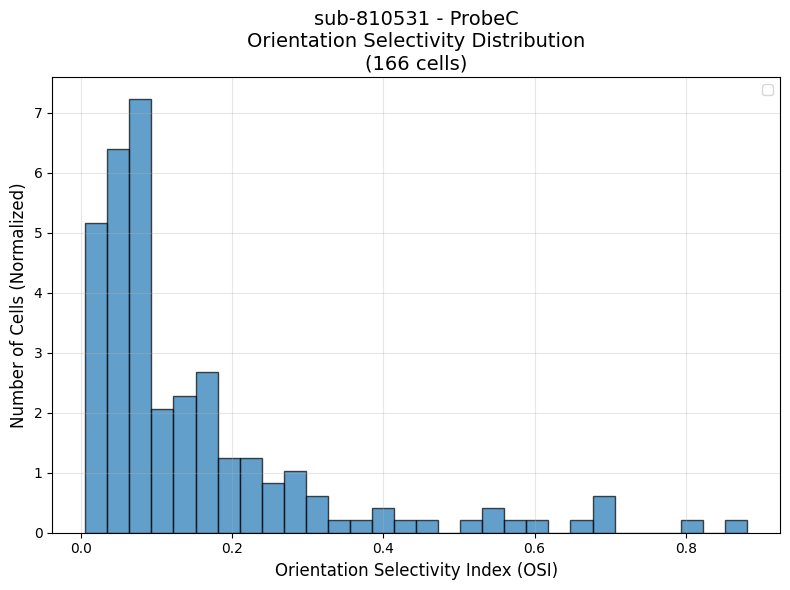

Orientation selective cells: 166 / 198 (83.8%)
Median OSI: 0.083
Mean OSI: 0.151
✓ Saved figure to: X:\Personnel\MaryBeth\OpenScope\001568\sub-810531\ProbeC\dsi_distribution_filtered.png


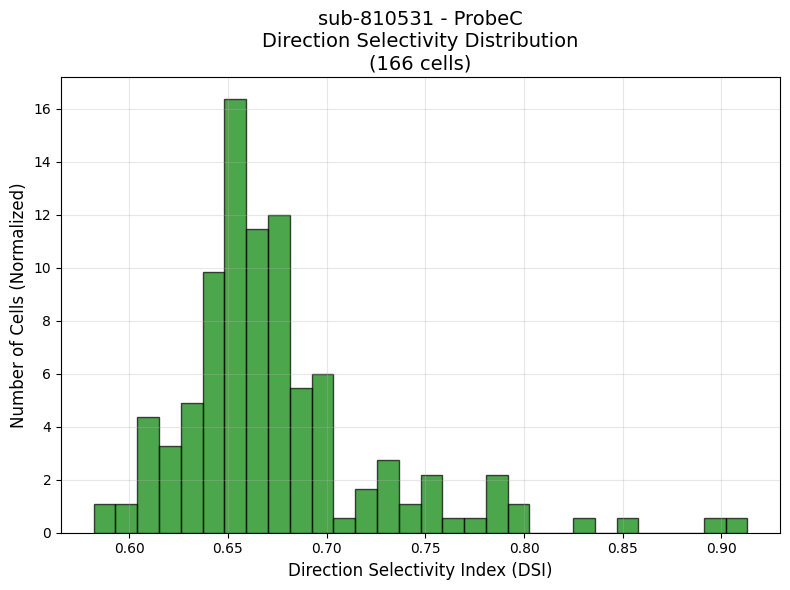

Direction selective cells: 166 / 198 (83.8%)
Median DSI: 0.663
Mean DSI: 0.675
✓ Saved figure to: X:\Personnel\MaryBeth\OpenScope\001568\sub-810531\ProbeC\preferred_orientation_filtered.png


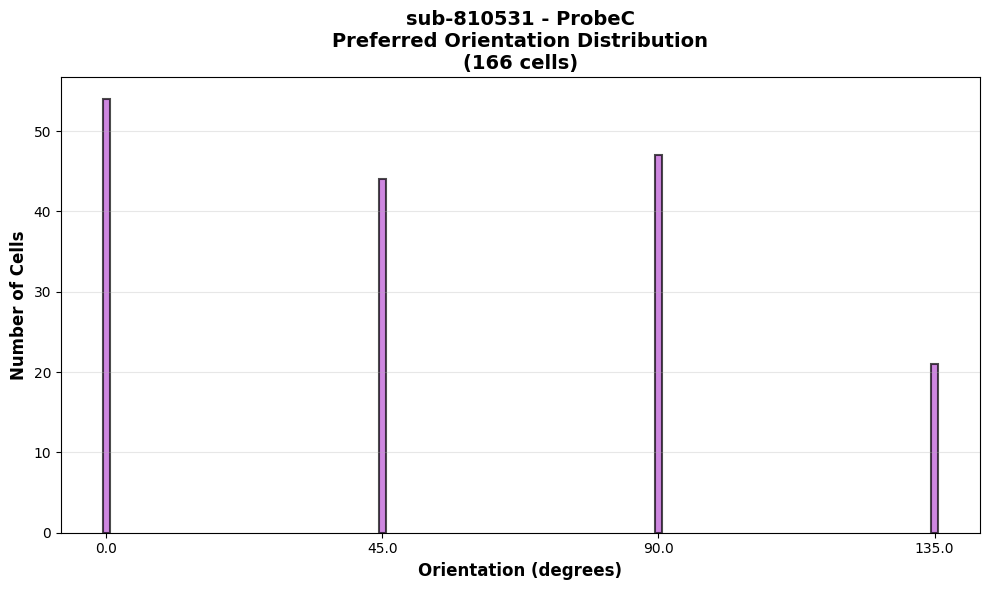

Responsive cells: 166 / 198 (83.8%)
✓ Saved figure to: X:\Personnel\MaryBeth\OpenScope\001568\sub-810531\ProbeC\preferred_temporal_frequency_filtered.png


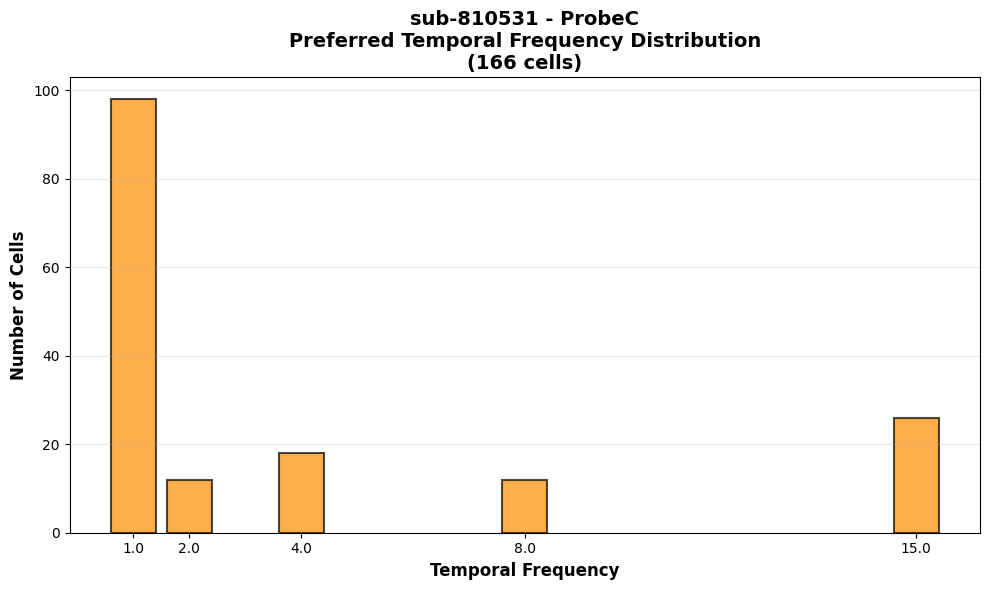

Responsive cells: 166 / 198 (83.8%)
✓ Saved figure to: X:\Personnel\MaryBeth\OpenScope\001568\sub-810531\ProbeC\preferred_spatial_frequency_filtered.png


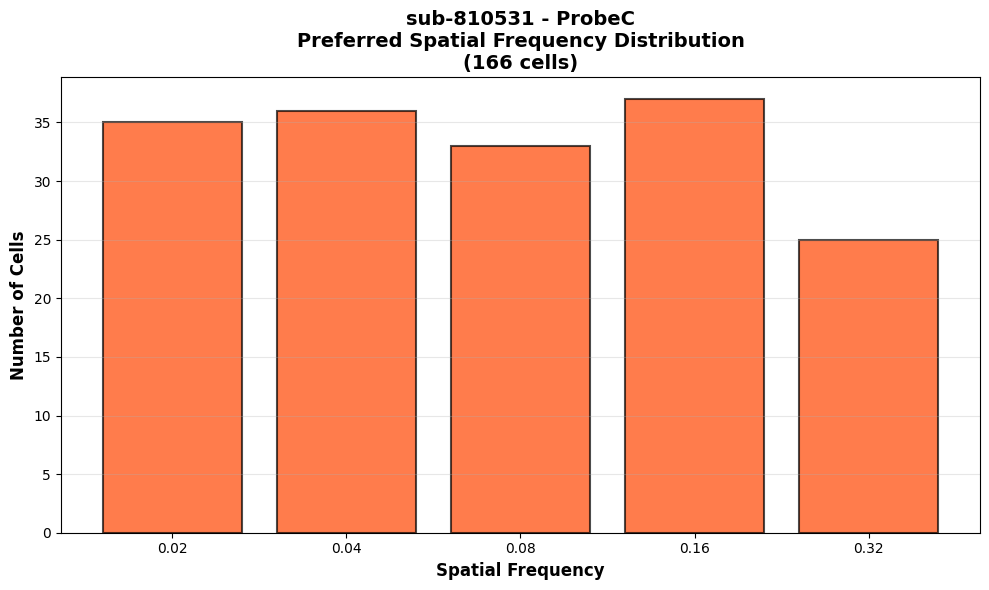

Responsive cells: 166 / 198 (83.8%)
Debug info:
  Total filtered units: 198
  Units in results_df: 198
  Overlap: 198
Bounded fit failed, trying unbounded fit: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Bounded fit failed, trying unbounded fit: Optimal parameters not found: The maximum number of function evaluations is exceeded.
✓ Saved figure to: X:\Personnel\MaryBeth\OpenScope\001568\sub-810531\ProbeC\rf_centers_by_preferred_orientation_filtered.png
Plotted RF centers: 198 cells with 4 unique orientations
Debug info:
  Total filtered units: 198
  Units in results_df: 198
  Overlap: 198
Bounded fit failed, trying unbounded fit: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Bounded fit failed, trying unbounded fit: Optimal parameters not found: The maximum number of function evaluations is exceeded.
✓ Saved figure to: X:\Personnel\MaryBeth\OpenScope\001568\sub-810531\ProbeC\rf_centers_by_preferred_tf_fil

c:\Users\MaryBeth\anaconda3\envs\openscope\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


KeyboardInterrupt: 

In [16]:
parent_folder = r"X:\Personnel\MaryBeth\OpenScope\001568"

results = {}

subfolder_colors = {}
color_palette = plt.cm.tab10(np.linspace(0, 1, 10))

with os.scandir(parent_folder) as entries:

    for entry in entries:
        if entry.is_dir():
            print(entry.name)
            mouse_dir = os.path.join(parent_folder, entry.name)
            nwb_file = next((f for f in os.listdir(mouse_dir) if f.lower().endswith('.nwb')), None)

            if nwb_file is None:
                print(f"No .nwb file found in {entry.name}, skipping.")
                continue

            if entry.name not in subfolder_colors:
                subfolder_colors[entry.name] = color_palette[len(subfolder_colors) % 10]
            
            results[entry.name] = {}

            nwb_path = os.path.join(mouse_dir, nwb_file)
            print(f"Found: {nwb_file}")

            io = NWBHDF5IO(nwb_path, "r", load_namespaces=True)
                   
            nwb = io.read()
            
            units = nwb.units
            print(f"Total units: {len(units)}")

            units_table = nwb.units.to_dataframe()

            dg_stim_table = nwb.intervals["drifting_gratings_field_block_presentations"].to_dataframe()
            presentation_ids = dg_stim_table.index.values

            conditionwise_stats, stimulus_conditions = conditionwise_spike_statistics(
                nwb,
                stimulus_block='drifting_gratings_field_block_presentations',
                stimulus_presentation_ids=presentation_ids,
                unit_ids=None
            )

            # convert strings to floats
            dg_stim_table['orientation'] = dg_stim_table['orientation'].astype(float)
            dg_stim_table['temporal_frequency'] = dg_stim_table['temporal_frequency'].astype(float)
            dg_stim_table['spatial_frequency'] = dg_stim_table['spatial_frequency'].astype(float)

            # Now stimulus_conditions already has the conditions filtered to dg
            dg_conditions = stimulus_conditions

            # Get orientation and temporal frequency values
            ori_vals = np.sort(dg_conditions['orientation'].unique())
            tf_vals = np.sort(dg_conditions['temporal_frequency'].unique())
            sf_vals = np.sort(dg_conditions['spatial_frequency'].unique())

            orivals = np.sort(dg_stim_table['orientation'].dropna().unique())
            tfvals = np.sort(dg_stim_table['temporal_frequency'].dropna().unique())

            channel_probes = {nwb.electrodes["id"][i]: nwb.electrodes["group_name"][i] for i in range(len(nwb.electrodes))}
            
            for probe in set(channel_probes.values()):
                print(probe)
                probe_dir = os.path.join(mouse_dir, probe)
                os.makedirs(probe_dir, exist_ok=True)

                # get units for the probe
                selected_unit_idxs = []
                for unit_idx in range(len(units)):
                    if select_condition(unit_idx, units, probe):
                        selected_unit_idxs.append(unit_idx)
                         
                if len(selected_unit_idxs) == 0:
                    print(f"WARNING: No units found for probe {probe} in {nwb_file}")
                    continue 
                else: 
                    print(f"Selected {len(selected_unit_idxs)} units for {probe}")
                    rf_stim_table = nwb.intervals["receptive_field_block_presentations"].to_dataframe()
                    print(rf_stim_table.columns.tolist())

                    xs = list(set(rf_stim_table.x_position))
                    ys = list(set(rf_stim_table.y_position))

                    xs = [float(x) for x in xs]
                    ys = [float(y) for y in ys]

                    xs = np.sort(xs)
                    ys = np.sort(ys)
                    print(xs)
                    print(ys)

                unit_rfs = []
                for unit_idx in selected_unit_idxs:
                    unit_spike_times = units["spike_times"][unit_idx]
                    unit_rfs.append(get_rf(unit_spike_times, xs, ys, rf_stim_table))

                # Filter RFs based on Gaussian fit
                filtered_rfs, filtered_indices, r_squared_values, fitted_rfs = filter_rfs_by_gaussian_fit(
                    unit_rfs, 
                    r_squared_threshold=0.5,
                    verbose=True
                )
                
                filtered_unit_idxs = [selected_unit_idxs[i] for i in filtered_indices]

                if analysis_mode == 'filtered':
                    # Use only units with good RFs
                    units_to_analyze = filtered_unit_idxs
                    print(f"Analyzing {len(units_to_analyze)} units with good RFs...")
                    include_rf_quality = True
                    
                elif analysis_mode == 'all':
                    # Use all units
                    units_to_analyze = selected_unit_idxs
                    print(f"Analyzing ALL {len(selected_unit_idxs)} units...")
                    include_rf_quality = False
                    
                elif isinstance(analysis_mode, int):
                    # Use specified number of units
                    if analysis_mode <= len(filtered_unit_idxs):
                        # If number is less than filtered units, take from filtered
                        units_to_analyze = filtered_unit_idxs[:analysis_mode]
                        print(f"Analyzing {len(units_to_analyze)} units from filtered set...")
                        include_rf_quality = True
                    else:
                        # If number is more than filtered units, take from all units
                        units_to_analyze = selected_unit_idxs[:analysis_mode]
                        print(f"Analyzing {len(units_to_analyze)} units from all units...")
                        include_rf_quality = False
                else:
                    raise ValueError("analysis_mode must be 'filtered', 'all', or an integer")
                
                # Run analysis - NEW METHOD
                all_results = []
                failed_count = 0

                for idx, unit_idx in enumerate(units_to_analyze):
                    if idx % 50 == 0:
                        print(f"Processing unit {idx}/{len(units_to_analyze)}...")
                    
                    try:
                        # Get SNR
                        snr = units["snr"][unit_idx]

                        # Find preferred temporal frequency
                        tf_responses = []
                        for tf in tf_vals:
                            tf_conditions = dg_conditions[dg_conditions['temporal_frequency'] == tf].index.values
                            try:
                                mean_response = conditionwise_stats.loc[unit_idx].loc[tf_conditions]['spike_mean'].mean()
                                mean_response = float(mean_response)
                            except (KeyError, ValueError, TypeError):
                                mean_response = 0.0
                            tf_responses.append(mean_response)
                        
                        pref_tf = tf_vals[np.argmax(tf_responses)]

                        # Find preferred orientation at preferred temporal frequency
                        ori_responses = []
                        for ori in ori_vals:
                            # Filter for conditions with preferred TF and this orientation
                            ori_tf_conditions = dg_conditions[
                                (dg_conditions['temporal_frequency'] == pref_tf) & 
                                (dg_conditions['orientation'] == ori)
                            ].index.values
                            
                            try:
                                mean_response = conditionwise_stats.loc[unit_idx].loc[ori_tf_conditions]['spike_mean'].mean()
                                mean_response = float(mean_response)
                            except (KeyError, ValueError, TypeError):
                                mean_response = 0.0
                            ori_responses.append(mean_response)
                        
                        pref_ori = ori_vals[np.argmax(ori_responses)]

                        # Find preferred spatial frequency at preferred temporal frequency
                        sf_responses = []
                        for sf in sf_vals:
                            # Filter for conditions with preferred TF and this orientation
                            sf_tf_conditions = dg_conditions[
                                (dg_conditions['temporal_frequency'] == pref_tf) & 
                                (dg_conditions['spatial_frequency'] == sf)
                            ].index.values
                            
                            try:
                                mean_response = conditionwise_stats.loc[unit_idx].loc[sf_tf_conditions]['spike_mean'].mean()
                                mean_response = float(mean_response)
                            except (KeyError, ValueError, TypeError):
                                mean_response = 0.0
                            sf_responses.append(mean_response)
                        
                        pref_sf = sf_vals[np.argmax(sf_responses)]
                                                    
                        # Filter conditions to only those at the preferred temporal frequency
                        dg_conditions_at_pref_tf = dg_conditions[dg_conditions['temporal_frequency'] == pref_tf]

                        # Get unique orientations at this temporal frequency
                        ori_at_pref_tf = np.sort(dg_conditions_at_pref_tf['orientation'].unique())

                        # Calculate OSI and DSI
                        my_osi, my_dsi = calculate_osi_dsi(unit_idx, pref_tf, conditionwise_stats, dg_conditions, ori_at_pref_tf)
                        
                        # Ensure OSI and DSI are numeric
                        my_osi = float(my_osi) if not np.isnan(my_osi) else np.nan
                        my_dsi = float(my_dsi) if not np.isnan(my_dsi) else np.nan
                        
                        # Skip units with no valid responses
                        if np.isnan(my_osi) or (my_osi == 0 and my_dsi == 0):
                            failed_count += 1
                            continue
                        
                        # Store results
                        result = {
                            'unit_id': unit_idx,
                            'pref_ori': float(pref_ori),
                            'pref_tf': float(pref_tf),
                            'pref_sf': float(pref_sf),
                            'osi_dg': my_osi,
                            'dsi_dg': my_dsi,
                            'peak_dff_dg': max(ori_responses),
                            'snr': snr,
                            'probe': probe                        
                            }
                        
                        # Add RF center coordinates if this unit is in filtered units
                        if unit_idx in filtered_unit_idxs:
                            # Get the index in filtered_unit_idxs
                            filtered_idx = filtered_unit_idxs.index(unit_idx)
                            rf = filtered_rfs[filtered_idx]
                            
                            # Fit Gaussian to get center
                            popt, r_squared, _ = fit_gaussian_to_rf(rf)
                            
                            if popt is not None:
                                x_idx = popt[1]
                                y_idx = popt[2]
                                x_pos = np.interp(x_idx, np.arange(len(xs)), xs)
                                y_pos = np.interp(y_idx, np.arange(len(ys)), ys)
                                
                                result['rf_x_center'] = x_pos
                                result['rf_y_center'] = y_pos
                                result['rf_r_squared'] = r_squared
                            else:
                                result['rf_x_center'] = np.nan
                                result['rf_y_center'] = np.nan
                                result['rf_r_squared'] = np.nan
                        else:
                            # Not in filtered units, so no RF data
                            result['rf_x_center'] = np.nan
                            result['rf_y_center'] = np.nan
                            result['rf_r_squared'] = np.nan
                        
                        all_results.append(result)
                        
                    except Exception as e:
                        print(f"Error on unit {unit_idx}: {e}")
                        import traceback
                        traceback.print_exc()
                        failed_count += 1
                        continue

                # Convert to DataFrame
                if len(all_results) > 0:
                    # Build DataFrame with all columns
                    df_dict = {
                        'unit_id': [r['unit_id'] for r in all_results],
                        'pref_ori': [r['pref_ori'] for r in all_results],
                        'pref_tf': [r['pref_tf'] for r in all_results],
                        'pref_sf': [r['pref_sf'] for r in all_results],
                        'osi_dg': [r['osi_dg'] for r in all_results],
                        'dsi_dg': [r['dsi_dg'] for r in all_results],
                        'peak_dff_dg': [r['peak_dff_dg'] for r in all_results],
                        'rf_x_center': [r['rf_x_center'] for r in all_results],
                        'rf_y_center': [r['rf_y_center'] for r in all_results],
                        'rf_r_squared': [r['rf_r_squared'] for r in all_results],
                        'snr': [r['snr'] for r in all_results],
                        'probe': [r['probe'] for r in all_results]
                    }
                    
                    results_df = pd.DataFrame(df_dict)

                    print(f"\n{'='*60}")
                    print(f"Orientation Selectivity Analysis Complete:")
                    print(f"  Successfully analyzed: {len(results_df)} units")
                    print(f"  Failed/skipped: {failed_count} units")
                    if len(results_df) + failed_count > 0:
                        print(f"  Success rate: {len(results_df)/(len(results_df)+failed_count)*100:.1f}%")
                    print(f"{'='*60}")
                    
                    # Create filename suffix based on analysis mode
                    if analysis_mode == 'filtered':
                        mode_suffix = 'filtered'
                    elif analysis_mode == 'all':
                        mode_suffix = 'all'
                    else:
                        mode_suffix = f'{analysis_mode}units'
                    
                    # Save results with proper path and naming
                    output_file = os.path.join(probe_dir, f'metrics_{mode_suffix}.csv')
                    results_df.to_csv(output_file, index=False)
                    print(f"\nResults saved to {output_file}")

                    subset_df = results_df[results_df['unit_id'].isin(units_to_analyze)]

                    # Plot orientation selectivity distribution
                    osi_save_path = os.path.join(probe_dir, f'osi_distribution_{mode_suffix}.png')
                    plot_orientation_selectivity(subset_df, n_hist_bins=30, peak_dff_min=1.0, 
                                                save_path=osi_save_path, probe_name=probe, mouse_name=entry.name)

                    # Plot direction selectivity distribution
                    dsi_save_path = os.path.join(probe_dir, f'dsi_distribution_{mode_suffix}.png')
                    plot_direction_selectivity(subset_df, n_hist_bins=30, peak_dff_min=1.0, 
                                            save_path=dsi_save_path, probe_name=probe, mouse_name=entry.name)

                    # Plot preferred orientation distribution (bar)
                    pref_ori_save_path = os.path.join(probe_dir, f'preferred_orientation_{mode_suffix}.png')
                    plot_preferred_orientation_bar(subset_df, peak_dff_min=1.0, 
                                            save_path=pref_ori_save_path, probe_name=probe, mouse_name=entry.name)

                    # Plot preferred temporal frequency distribution (bar)
                    pref_tf_save_path = os.path.join(probe_dir, f'preferred_temporal_frequency_{mode_suffix}.png')
                    plot_preferred_tf_bar(subset_df, peak_dff_min=1.0, 
                                                    save_path=pref_tf_save_path, probe_name=probe, mouse_name=entry.name)
                    
                    # Plot preferred temporal frequency distribution (bar)
                    pref_sf_save_path = os.path.join(probe_dir, f'preferred_spatial_frequency_{mode_suffix}.png')
                    plot_preferred_sf_bar(subset_df, peak_dff_min=1.0, 
                                                    save_path=pref_sf_save_path, probe_name=probe, mouse_name=entry.name)
                    
                    if analysis_mode == 'filtered':
                        # Plot RF centers colored by preferred orientation
                        rf_ori_save_path = os.path.join(probe_dir, f'rf_centers_by_preferred_orientation_{mode_suffix}.png')
                        plot_preferred_orientation_by_rf(filtered_unit_idxs, filtered_rfs,
                                results_df, xs, ys,
                                save_path=rf_ori_save_path, probe_name=probe, mouse_name=entry.name)
                        
                        # Plot RF centers colored by preferred temporal frequency
                        rf_tf_save_path = os.path.join(probe_dir, f'rf_centers_by_preferred_tf_{mode_suffix}.png')
                        plot_preferred_tf_by_rf(filtered_unit_idxs, filtered_rfs,
                                results_df, xs, ys,
                                save_path=rf_tf_save_path, probe_name=probe, mouse_name=entry.name)
                        
                        # Plot RF centers colored by preferred spatial frequency
                        rf_sf_save_path = os.path.join(probe_dir, f'rf_centers_by_preferred_sf_{mode_suffix}.png')
                        plot_preferred_sf_by_rf(filtered_unit_idxs, filtered_rfs,
                                results_df, xs, ys,
                                save_path=rf_sf_save_path, probe_name=probe, mouse_name=entry.name)
                        
                        # Plot RF X position vs preferred orientation
                        rf_x_ori_save_path = os.path.join(probe_dir, f'rf_x_position_vs_pref_ori_{mode_suffix}.png')
                        rf_y_ori_save_path = os.path.join(probe_dir, f'rf_y_position_vs_pref_ori_{mode_suffix}.png')
                        plot_rf_position_vs_pref_ori(filtered_unit_idxs, filtered_rfs,
                                results_df, xs, ys,
                                save_path_x=rf_x_ori_save_path,
                                save_path_y=rf_y_ori_save_path,
                                probe_name=probe, mouse_name=entry.name)
                        
                        # Plot RF X position vs preferred temporal frequency
                        rf_x_tf_save_path = os.path.join(probe_dir, f'rf_x_position_vs_pref_tf_{mode_suffix}.png')
                        rf_y_tf_save_path = os.path.join(probe_dir, f'rf_y_position_vs_pref_tf_{mode_suffix}.png')
                        plot_rf_position_vs_pref_tf(filtered_unit_idxs, filtered_rfs,
                                results_df, xs, ys,
                                save_path_x=rf_x_tf_save_path,
                                save_path_y=rf_y_tf_save_path,
                                probe_name=probe, mouse_name=entry.name)
                        
                        # Plot RF X position vs preferred spatial frequency
                        rf_x_sf_save_path = os.path.join(probe_dir, f'rf_x_position_vs_pref_sf_{mode_suffix}.png')
                        rf_y_sf_save_path = os.path.join(probe_dir, f'rf_y_position_vs_pref_sf_{mode_suffix}.png')
                        plot_rf_position_vs_pref_sf(filtered_unit_idxs, filtered_rfs,
                                results_df, xs, ys,
                                save_path_x=rf_x_sf_save_path,
                                save_path_y=rf_y_sf_save_path,
                                probe_name=probe, mouse_name=entry.name)

                
            io.close()
            print()

## For all mice

In [ ]:
def plot_rf_position_vs_pref_ori_from_csv(combined_df, save_path_x=None, save_path_y=None,
                                          probe_name=None, mouse_name=None):
    """
    Create scatter plots from CSV data with RF centers already computed
    """
    # Filter out rows without RF center data
    df = combined_df.dropna(subset=['rf_x_center', 'rf_y_center'])
    
    if len(df) == 0:
        print("No valid RF center data found")
        return
    
    x_positions = df['rf_x_center'].values
    y_positions = df['rf_y_center'].values
    preferred_oris = df['pref_ori'].values
    
    unique_oris = np.unique(preferred_oris)
    n_orientations = len(unique_oris)
    
    if n_orientations == 4:
        ori_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#ff7f00']
    else:
        ori_colors = plt.cm.tab20(np.linspace(0, 1, n_orientations))
    
    base_title_suffix = f'\n({len(df)} cells)'
    if mouse_name and probe_name:
        base_title = f'{mouse_name} - {probe_name}'
    elif probe_name:
        base_title = f'{probe_name}'
    elif mouse_name:
        base_title = f'{mouse_name}'
    else:
        base_title = ''
    
    # Plot 1: X position vs Preferred Orientation
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    
    for i, ori in enumerate(unique_oris):
        ori_mask = (preferred_oris == ori)
        ax1.scatter(x_positions[ori_mask], preferred_oris[ori_mask], 
                   color=ori_colors[i], label=f'{int(ori)}°', s=100, alpha=0.7)
    
    ax1.set_xlabel('RF Center X Position (degrees)', fontsize=14)
    ax1.set_ylabel('Preferred Orientation (degrees)', fontsize=14)
    
    title1 = 'RF X Position vs Preferred Orientation'
    if base_title:
        title1 = base_title + '\n' + title1 + base_title_suffix
    else:
        title1 = title1 + base_title_suffix
    
    ax1.set_title(title1, fontsize=16, fontweight='bold', pad=20)
    ax1.legend(title='Preferred Orientation', bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=10, title_fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path_x:
        plt.savefig(save_path_x, dpi=300, bbox_inches='tight')
        print(f"✓ Saved X position figure to: {save_path_x}")
    
    plt.close()
    
    # Plot 2: Y position vs Preferred Orientation
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    
    for i, ori in enumerate(unique_oris):
        ori_mask = (preferred_oris == ori)
        ax2.scatter(y_positions[ori_mask], preferred_oris[ori_mask], 
                   color=ori_colors[i], label=f'{int(ori)}°', s=100, alpha=0.7)
    
    ax2.set_xlabel('RF Center Y Position (degrees)', fontsize=14)
    ax2.set_ylabel('Preferred Orientation (degrees)', fontsize=14)
    
    title2 = 'RF Y Position vs Preferred Orientation'
    if base_title:
        title2 = base_title + '\n' + title2 + base_title_suffix
    else:
        title2 = title2 + base_title_suffix
    
    ax2.set_title(title2, fontsize=16, fontweight='bold', pad=20)
    ax2.legend(title='Preferred Orientation', bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=10, title_fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path_y:
        plt.savefig(save_path_y, dpi=300, bbox_inches='tight')
        print(f"✓ Saved Y position figure to: {save_path_y}")
    
    plt.close()
    
    print(f"Plotted {len(df)} cells with {n_orientations} unique orientations")


def plot_rf_position_vs_pref_tf_from_csv(combined_df, save_path_x=None, save_path_y=None,
                                         probe_name=None, mouse_name=None):
    """
    Create scatter plots from CSV data with RF centers already computed
    """
    # Filter out rows without RF center data
    df = combined_df.dropna(subset=['rf_x_center', 'rf_y_center'])
    
    if len(df) == 0:
        print("No valid RF center data found")
        return
    
    x_positions = df['rf_x_center'].values
    y_positions = df['rf_y_center'].values
    preferred_tfs = df['pref_tf'].values
    
    unique_tfs = np.unique(preferred_tfs)
    n_tfs = len(unique_tfs)
    
    if n_tfs <= 10:
        tf_colors = plt.cm.tab10(np.linspace(0, 1, n_tfs))
    else:
        tf_colors = plt.cm.tab20(np.linspace(0, 1, n_tfs))
    
    base_title_suffix = f'\n({len(df)} cells)'
    if mouse_name and probe_name:
        base_title = f'{mouse_name} - {probe_name}'
    elif probe_name:
        base_title = f'{probe_name}'
    elif mouse_name:
        base_title = f'{mouse_name}'
    else:
        base_title = ''
    
    # Plot 1: X position vs Preferred TF
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    
    for i, tf in enumerate(unique_tfs):
        tf_mask = (preferred_tfs == tf)
        ax1.scatter(x_positions[tf_mask], preferred_tfs[tf_mask], 
                   color=tf_colors[i], label=f'{tf}', s=100, alpha=0.7)
    
    ax1.set_xlabel('RF Center X Position (degrees)', fontsize=14)
    ax1.set_ylabel('Preferred Temporal Frequency', fontsize=14)
    
    title1 = 'RF X Position vs Preferred Temporal Frequency'
    if base_title:
        title1 = base_title + '\n' + title1 + base_title_suffix
    else:
        title1 = title1 + base_title_suffix
    
    ax1.set_title(title1, fontsize=16, fontweight='bold', pad=20)
    ax1.legend(title='Preferred TF', bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=10, title_fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path_x:
        plt.savefig(save_path_x, dpi=300, bbox_inches='tight')
        print(f"✓ Saved X position figure to: {save_path_x}")
    
    plt.close()
    
    # Plot 2: Y position vs Preferred TF
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    
    for i, tf in enumerate(unique_tfs):
        tf_mask = (preferred_tfs == tf)
        ax2.scatter(y_positions[tf_mask], preferred_tfs[tf_mask], 
                   color=tf_colors[i], label=f'{tf}', s=100, alpha=0.7)
    
    ax2.set_xlabel('RF Center Y Position (degrees)', fontsize=14)
    ax2.set_ylabel('Preferred Temporal Frequency', fontsize=14)
    
    title2 = 'RF Y Position vs Preferred Temporal Frequency'
    if base_title:
        title2 = base_title + '\n' + title2 + base_title_suffix
    else:
        title2 = title2 + base_title_suffix
    
    ax2.set_title(title2, fontsize=16, fontweight='bold', pad=20)
    ax2.legend(title='Preferred TF', bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=10, title_fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path_y:
        plt.savefig(save_path_y, dpi=300, bbox_inches='tight')
        print(f"✓ Saved Y position figure to: {save_path_y}")
    
    plt.close()
    
    print(f"Plotted {len(df)} cells with {n_tfs} unique temporal frequencies")


def plot_rf_position_vs_pref_sf_from_csv(combined_df, save_path_x=None, save_path_y=None,
                                         probe_name=None, mouse_name=None):
    """
    Create scatter plots from CSV data with RF centers already computed
    """
    # Filter out rows without RF center data
    df = combined_df.dropna(subset=['rf_x_center', 'rf_y_center'])
    
    if len(df) == 0:
        print("No valid RF center data found")
        return
    
    x_positions = df['rf_x_center'].values
    y_positions = df['rf_y_center'].values
    preferred_sfs = df['pref_sf'].values
    
    unique_sfs = np.unique(preferred_sfs)
    n_sfs = len(unique_sfs)
    
    if n_sfs <= 10:
        sf_colors = plt.cm.tab10(np.linspace(0, 1, n_sfs))
    else:
        sf_colors = plt.cm.tab20(np.linspace(0, 1, n_sfs))
    
    base_title_suffix = f'\n({len(df)} cells)'
    if mouse_name and probe_name:
        base_title = f'{mouse_name} - {probe_name}'
    elif probe_name:
        base_title = f'{probe_name}'
    elif mouse_name:
        base_title = f'{mouse_name}'
    else:
        base_title = ''
    
    # Plot 1: X position vs Preferred SF
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    
    for i, sf in enumerate(unique_sfs):
        sf_mask = (preferred_sfs == sf)
        ax1.scatter(x_positions[sf_mask], preferred_sfs[sf_mask], 
                   color=sf_colors[i], label=f'{sf}', s=100, alpha=0.7)
    
    ax1.set_xlabel('RF Center X Position (degrees)', fontsize=14)
    ax1.set_ylabel('Preferred Spatial Frequency', fontsize=14)
    
    title1 = 'RF X Position vs Preferred Spatial Frequency'
    if base_title:
        title1 = base_title + '\n' + title1 + base_title_suffix
    else:
        title1 = title1 + base_title_suffix
    
    ax1.set_title(title1, fontsize=16, fontweight='bold', pad=20)
    ax1.legend(title='Preferred SF', bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=10, title_fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path_x:
        plt.savefig(save_path_x, dpi=300, bbox_inches='tight')
        print(f"✓ Saved X position figure to: {save_path_x}")
    
    plt.close()
    
    # Plot 2: Y position vs Preferred SF
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    
    for i, sf in enumerate(unique_sfs):
        sf_mask = (preferred_sfs == sf)
        ax2.scatter(y_positions[sf_mask], preferred_sfs[sf_mask], 
                   color=sf_colors[i], label=f'{sf}', s=100, alpha=0.7)
    
    ax2.set_xlabel('RF Center Y Position (degrees)', fontsize=14)
    ax2.set_ylabel('Preferred Spatial Frequency', fontsize=14)
    
    title2 = 'RF Y Position vs Preferred Spatial Frequency'
    if base_title:
        title2 = base_title + '\n' + title2 + base_title_suffix
    else:
        title2 = title2 + base_title_suffix
    
    ax2.set_title(title2, fontsize=16, fontweight='bold', pad=20)
    ax2.legend(title='Preferred SF', bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=10, title_fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path_y:
        plt.savefig(save_path_y, dpi=300, bbox_inches='tight')
        print(f"✓ Saved Y position figure to: {save_path_y}")
    
    plt.close()
    
    print(f"Plotted {len(df)} cells with {n_sfs} unique spatial frequencies")

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

analysis_mode = 'filtered'  # or 'all' or a number
mode_suffix = 'filtered'  # adjust based on analysis_mode

# Dictionary to store accumulated data by probe
probe_data = {}

# Iterate through all mouse directories
with os.scandir(parent_folder) as entries:
    for entry in entries:
        if entry.is_dir():
            mouse_dir = os.path.join(parent_folder, entry.name)
            
            # Look for probe subdirectories
            if os.path.exists(mouse_dir):
                for item in os.listdir(mouse_dir):
                    probe_path = os.path.join(mouse_dir, item)
                    
                    # Check if it's a directory (probe folder)
                    if os.path.isdir(probe_path):
                        probe_name = item
                        
                        # Look for the metrics CSV file
                        csv_file = os.path.join(probe_path, f'metrics_{mode_suffix}.csv')
                        
                        if os.path.exists(csv_file):
                            print(f"Loading: {entry.name}/{probe_name}")
                            
                            # Read the CSV
                            df = pd.read_csv(csv_file)
                            
                            # Add mouse identifier to the data
                            df['mouse_name'] = entry.name
                            
                            # Accumulate data by probe
                            if probe_name not in probe_data:
                                probe_data[probe_name] = []
                            probe_data[probe_name].append(df)

# Combine data for each probe and create plots
for probe_name, dfs in probe_data.items():
    print(f"\nProcessing combined data for probe: {probe_name}")
    
    # Concatenate all dataframes for this probe
    combined_df = pd.concat(dfs, ignore_index=True)
    
    print(f"  Total cells across all mice: {len(combined_df)}")
    print(f"  Mice included: {combined_df['mouse_name'].unique()}")
    
    # Create output directory for combined plots
    combined_dir = os.path.join(parent_folder, f"combined_{probe_name}")
    os.makedirs(combined_dir, exist_ok=True)
    
    # Plot orientation selectivity distribution
    osi_save_path = os.path.join(combined_dir, f'osi_distribution_combined_{mode_suffix}.png')
    plot_orientation_selectivity(combined_df, n_hist_bins=30, peak_dff_min=1.0, 
                                save_path=osi_save_path, probe_name=probe_name, 
                                mouse_name=f"All Mice (n={len(dfs)})")

    # Plot direction selectivity distribution
    dsi_save_path = os.path.join(combined_dir, f'dsi_distribution_combined_{mode_suffix}.png')
    plot_direction_selectivity(combined_df, n_hist_bins=30, peak_dff_min=1.0, 
                            save_path=dsi_save_path, probe_name=probe_name, 
                            mouse_name=f"All Mice (n={len(dfs)})")

    # Plot preferred orientation distribution (bar) - regular
    pref_ori_save_path = os.path.join(combined_dir, f'preferred_orientation_combined_{mode_suffix}.png')
    plot_preferred_orientation_bar(combined_df, peak_dff_min=1.0, 
                            save_path=pref_ori_save_path, probe_name=probe_name, 
                            mouse_name=f"All Mice (n={len(dfs)})")
    
    # Plot preferred orientation distribution (bar) - normalized
    pref_ori_save_path_norm = os.path.join(combined_dir, f'preferred_orientation_combined_{mode_suffix}_normalized.png')
    plot_preferred_orientation_bar(combined_df, peak_dff_min=1.0, 
                            save_path=pref_ori_save_path_norm, probe_name=probe_name, 
                            mouse_name=f"All Mice (n={len(dfs)})", normalize=True)

    # Plot preferred temporal frequency distribution (bar) - regular
    pref_tf_save_path = os.path.join(combined_dir, f'preferred_temporal_frequency_combined_{mode_suffix}.png')
    plot_preferred_tf_bar(combined_df, peak_dff_min=1.0, 
                        save_path=pref_tf_save_path, probe_name=probe_name, 
                        mouse_name=f"All Mice (n={len(dfs)})")
    
    # Plot preferred temporal frequency distribution (bar) - normalized
    pref_tf_save_path_norm = os.path.join(combined_dir, f'preferred_temporal_frequency_combined_{mode_suffix}_normalized.png')
    plot_preferred_tf_bar(combined_df, peak_dff_min=1.0, 
                        save_path=pref_tf_save_path_norm, probe_name=probe_name, 
                        mouse_name=f"All Mice (n={len(dfs)})", normalize=True)

    # Plot preferred spatial frequency distribution (bar) - regular
    pref_sf_save_path = os.path.join(combined_dir, f'preferred_spatial_frequency_combined_{mode_suffix}.png')
    plot_preferred_sf_bar(combined_df, peak_dff_min=1.0, 
                        save_path=pref_sf_save_path, probe_name=probe_name, 
                        mouse_name=f"All Mice (n={len(dfs)})")
    
    # Plot preferred spatial frequency distribution (bar) - normalized
    pref_sf_save_path_norm = os.path.join(combined_dir, f'preferred_spatial_frequency_combined_{mode_suffix}_normalized.png')
    plot_preferred_sf_bar(combined_df, peak_dff_min=1.0, 
                        save_path=pref_sf_save_path_norm, probe_name=probe_name, 
                        mouse_name=f"All Mice (n={len(dfs)})", normalize=True)
    
    
    # Plot RF X/Y position vs preferred orientation
    rf_x_ori_save_path = os.path.join(combined_dir, f'rf_x_position_vs_pref_ori_combined_{mode_suffix}.png')
    rf_y_ori_save_path = os.path.join(combined_dir, f'rf_y_position_vs_pref_ori_combined_{mode_suffix}.png')
    plot_rf_position_vs_pref_ori_from_csv(combined_df,
            save_path_x=rf_x_ori_save_path,
            save_path_y=rf_y_ori_save_path,
            probe_name=probe_name, 
            mouse_name=f"All Mice (n={len(dfs)})")

    # Plot RF X/Y position vs preferred temporal frequency
    rf_x_tf_save_path = os.path.join(combined_dir, f'rf_x_position_vs_pref_tf_combined_{mode_suffix}.png')
    rf_y_tf_save_path = os.path.join(combined_dir, f'rf_y_position_vs_pref_tf_combined_{mode_suffix}.png')
    plot_rf_position_vs_pref_tf_from_csv(combined_df,
            save_path_x=rf_x_tf_save_path,
            save_path_y=rf_y_tf_save_path,
            probe_name=probe_name, 
            mouse_name=f"All Mice (n={len(dfs)})")
    
    # Save combined CSV
    combined_csv_path = os.path.join(combined_dir, f'metrics_combined_{mode_suffix}.csv')
    combined_df.to_csv(combined_csv_path, index=False)
    print(f"  Saved combined data to: {combined_csv_path}")
    
    print(f"  ✓ All plots saved to: {combined_dir}")

print("\n" + "="*60)
print("Combined analysis complete!")
print(f"Probes analyzed: {list(probe_data.keys())}")
print("="*60)

## Multinomial Logistic Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt 
import seaborn as sns

import os

In [ ]:
df = pd.read_csv(r"C:\Users\MaryBeth\projects\SarvestaniLab\OpenScope\001568\combined_ProbeA\metrics_combined_filtered.csv")
variable = 'pref_ori'  # or 'pref_tf'

X = df[['rf_x_center', 'rf_y_center']].values
y = df[variable].values

orientation_counts = df[variable].value_counts()
print("orientation_counts")
print(orientation_counts)

chance_proportional = (orientation_counts/len(df))**2
print("chance_proportional:") 
print(chance_proportional)
chance_accuracy_proportional = chance_proportional.sum()
print("chance_accuracy_proportional:", chance_accuracy_proportional)

n_classes = len(orientation_counts)
chance_accuracy_uniform = 1/ n_classes
print("chance_accuracy_uniform:", chance_accuracy_uniform)




In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(
    multi_class = 'multinomial',
    solver = 'lbfgs',
    max_iter = 1000,
    random_state = 42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy:", accuracy)

## Do for all subdirectories (Discrete Variables)

In [ ]:
# Dictionary to store results
results = {}
all_data = {'pref_tf': [], 'pref_ori': [], 'pref_sf': [], 'rf_x': [], 'rf_y': []}

# Find all subdirectories containing metrics_combined_filtered.csv
for root, dirs, files in os.walk(parent_folder):
    if "metrics_combined_filtered.csv" in files:
        folder_name = os.path.basename(root)
        
        # Extract probe name (e.g., "ProbeE" from "combined_ProbeE")
        if folder_name.startswith("combined_"):
            probe_name = folder_name.replace("combined_", "")
        else:
            probe_name = folder_name
        
        csv_path = os.path.join(root, "metrics_combined_filtered.csv")
        
        print(f"Processing: {probe_name}")
        
        df = pd.read_csv(csv_path)
        results[probe_name] = {}
        
        # Collect data for concatenation
        for variable in ['pref_tf', 'pref_ori', 'pref_sf']:
            if variable in df.columns:
                all_data[variable].extend(df[variable].values)
                all_data['rf_x'].extend(df['rf_x_center'].values)
                all_data['rf_y'].extend(df['rf_y_center'].values)
        
        # Process both variables
        for variable in ['pref_tf', 'pref_ori', 'pref_sf']:
            if variable not in df.columns:
                continue
            
            print(f"\n  {variable}:")
            
            # Prepare data
            X = df[['rf_x_center', 'rf_y_center']].values
            y = df[variable].values
            
            # Multiply pref_sf by 100 for regression only
            if variable == 'pref_sf':
                y = y * 100
            
            # Convert to string labels to ensure they're treated as discrete classes
            y = y.astype(str)
            
            # Calculate chance accuracy
            orientation_counts = pd.Series(y).value_counts()
            print(f"    Orientation counts: {dict(orientation_counts)}")
            
            chance_proportional = (orientation_counts/len(y))**2
            chance_accuracy_proportional = chance_proportional.sum()
            print(f"    Chance accuracy (proportional): {chance_accuracy_proportional:.4f}")
            
            n_classes = len(orientation_counts)
            chance_accuracy_uniform = 1 / n_classes
            print(f"    Chance accuracy (uniform): {chance_accuracy_uniform:.4f}")
            
            # Train model
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            X_train, X_test, y_train, y_test = train_test_split(
                X_scaled, y, test_size=0.2, random_state=42, stratify=y
            )
            
            model = LogisticRegression(
                multi_class='multinomial',
                solver='lbfgs',
                max_iter=1000,
                random_state=42
            )
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print(f"    Model accuracy: {accuracy:.4f}")
            
            # Store results
            results[probe_name][variable] = {
                'accuracy': accuracy,
                'chance': chance_accuracy_proportional,
                'coefficients': model.coef_,
                'intercept': model.intercept_,
                'classes': model.classes_
            }
        
        print()

# Process concatenated data
print("="*60)
print("Processing: ALL_CONCATENATED")
results['All'] = {}

for variable in ['pref_tf', 'pref_ori', 'pref_sf']:
    if len(all_data[variable]) == 0:
        continue
    
    print(f"\n  {variable}:")
    
    # Prepare concatenated data
    n_samples = len(all_data[variable])
    X = np.column_stack([all_data['rf_x'][:n_samples], all_data['rf_y'][:n_samples]])
    y = np.array(all_data[variable])
    
    # Multiply pref_sf by 100 for regression only
    if variable == 'pref_sf':
        y = y * 100
    
    # Convert to string labels
    y = y.astype(str)
    
    # Calculate chance accuracy
    orientation_counts = pd.Series(y).value_counts()
    print(f"    Orientation counts: {dict(orientation_counts)}")
    
    chance_proportional = (orientation_counts/len(y))**2
    chance_accuracy_proportional = chance_proportional.sum()
    print(f"    Chance accuracy (proportional): {chance_accuracy_proportional:.4f}")
    
    n_classes = len(orientation_counts)
    chance_accuracy_uniform = 1 / n_classes
    print(f"    Chance accuracy (uniform): {chance_accuracy_uniform:.4f}")
    
    # Train model
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"    Model accuracy: {accuracy:.4f}")
    
    # Store results
    results['All'][variable] = {
        'accuracy': accuracy,
        'chance': chance_accuracy_proportional,
        'coefficients': model.coef_,
        'intercept': model.intercept_,
        'classes': model.classes_
    }

print()
print("="*60)

# Create the bar graph
probes = sorted([p for p in results.keys() if p != 'All'])
probes.append('All')  # Add concatenated at the end

variables = ['pref_tf', 'pref_ori', 'pref_sf']

# Colors for each variable
variable_colors = {
    'pref_tf': 'darkorange',
    'pref_ori': 'mediumorchid',
    'pref_sf': 'orangered'
}

fig, ax = plt.subplots(figsize=(16, 8))

bar_width = 0.8 / len(variables)
x = np.arange(len(probes))

for var_idx, variable in enumerate(variables):
    positions = x + var_idx * bar_width
    
    accuracies = []
    chances = []
    
    for probe in probes:
        if variable in results[probe]:
            accuracies.append(results[probe][variable]['accuracy'])
            chances.append(results[probe][variable]['chance'])
        else:
            accuracies.append(0)
            chances.append(0)
    
    color = variable_colors[variable]
    
    # Bars with white fill and colored edge for accuracy 
    ax.bar(positions, accuracies, bar_width, 
           label=f'{variable}', 
           color='white', 
           edgecolor=color, 
           linewidth=2)
    
    # Bars with colored fill for chance accuracy
    ax.bar(positions, chances, bar_width, 
           color=color, 
           alpha=0.7)
    
    # Add percent difference labels above bars
    for i, (pos, acc, chance) in enumerate(zip(positions, accuracies, chances)):
        if acc > 0 and chance > 0:  # Only add label if both values exist
            percent_diff = ((acc - chance) / chance) * 100
            # Position label slightly above the accuracy bar
            ax.text(pos, acc + 0.02, f'+{percent_diff:.1f}%', 
                   ha='center', va='bottom', fontsize=8, 
                   color=color, fontweight='bold')

ax.set_xlabel('Probe', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')

ax.set_title('Model Accuracy vs Chance Accuracy by Probe (Discrete Variables)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(probes, rotation=45, ha='right')
ax.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)  # Increased ylim to accommodate labels

plt.tight_layout()
plt.savefig(os.path.join(parent_folder, 'accuracy_discrete.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved!")

# Print summary
print("\nSummary:")
for probe in probes:
    print(f"\n{probe}:")
    if 'pref_tf' in results[probe]:
        print(f"  pref_tf - Accuracy: {results[probe]['pref_tf']['accuracy']:.4f}, Chance: {results[probe]['pref_tf']['chance']:.4f}")
    if 'pref_ori' in results[probe]:
        print(f"  pref_ori - Accuracy: {results[probe]['pref_ori']['accuracy']:.4f}, Chance: {results[probe]['pref_ori']['chance']:.4f}")

## Do for all subdirectories (Continuous Variables)

In [ ]:
# Dictionary to store results
results = {}
all_data = {'osi_dg': [], 'dsi_dg': [], 'rf_x': [], 'rf_y': []}

# Find all subdirectories containing metrics_combined_filtered.csv
for root, dirs, files in os.walk(parent_folder):
    if "metrics_combined_filtered.csv" in files:
        folder_name = os.path.basename(root)
        
        # Extract probe name (e.g., "ProbeE" from "combined_ProbeE")
        if folder_name.startswith("combined_"):
            probe_name = folder_name.replace("combined_", "")
        else:
            probe_name = folder_name
        
        csv_path = os.path.join(root, "metrics_combined_filtered.csv")
        
        print(f"Processing: {probe_name}")
        
        df = pd.read_csv(csv_path)
        results[probe_name] = {}
        
        # Collect data for concatenation
        for variable in ['osi_dg', 'dsi_dg']:
            if variable in df.columns:
                all_data[variable].extend(df[variable].values)
        if 'rf_x_center' in df.columns and 'rf_y_center' in df.columns:
            all_data['rf_x'].extend(df['rf_x_center'].values)
            all_data['rf_y'].extend(df['rf_y_center'].values)
        
        # Process both variables
        for variable in ['osi_dg', 'dsi_dg']:
            if variable not in df.columns:
                continue
            
            print(f"\n  {variable}:")
            
            # Prepare data
            X = df[['rf_x_center', 'rf_y_center']].values
            y = df[variable].values
            
            # Calculate baseline metrics for regression
            y_mean = y.mean()
            y_std = y.std()
            print(f"    Target variable - Mean: {y_mean:.4f}, Std: {y_std:.4f}")
            print(f"    Target variable - Range: [{y.min():.4f}, {y.max():.4f}]")
            
            # Calculate baseline R² (predicting mean)
            baseline_r2 = 0.0  # Always 0 when predicting mean
            print(f"    Baseline R² (mean prediction): {baseline_r2:.4f}")
            
            # Train model
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            X_train, X_test, y_train, y_test = train_test_split(
                X_scaled, y, test_size=0.2, random_state=42
            )
            
            model = LinearRegression()
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            # Evaluate regression performance
            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            
            print(f"    Model R²: {r2:.4f}")
            print(f"    Model RMSE: {rmse:.4f}")
            print(f"    Model MAE: {mae:.4f}")
            
            # Store results
            results[probe_name][variable] = {
                'r2': r2,
                'rmse': rmse,
                'mae': mae,
                'baseline_r2': baseline_r2,
                'coefficients': model.coef_,
                'intercept': model.intercept_
            }
        
        print()

# Process concatenated data
print("="*60)
print("Processing: ALL_CONCATENATED")
results['All'] = {}

for variable in ['osi_dg', 'dsi_dg']:
    if len(all_data[variable]) == 0:
        continue
    
    print(f"\n  {variable}:")
    
    # Prepare concatenated data
    n_samples = len(all_data[variable])
    X = np.column_stack([all_data['rf_x'][:n_samples], all_data['rf_y'][:n_samples]])
    y = np.array(all_data[variable])
    
    # Calculate baseline metrics for regression
    y_mean = y.mean()
    y_std = y.std()
    print(f"    Target variable - Mean: {y_mean:.4f}, Std: {y_std:.4f}")
    print(f"    Target variable - Range: [{y.min():.4f}, {y.max():.4f}]")
    
    # Calculate baseline R² (predicting mean)
    baseline_r2 = 0.0  # Always 0 when predicting mean
    print(f"    Baseline R² (mean prediction): {baseline_r2:.4f}")
    
    # Train model
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    
    model = LinearRegression()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate regression performance
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"    Model R²: {r2:.4f}")
    print(f"    Model RMSE: {rmse:.4f}")
    print(f"    Model MAE: {mae:.4f}")
    
    # Store results
    results['All'][variable] = {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'baseline_r2': baseline_r2,
        'coefficients': model.coef_,
        'intercept': model.intercept_
    }

print()
print("="*60)

# Create the bar graph
probes = sorted([p for p in results.keys() if p != 'All'])
probes.append('All')  # Add concatenated at the end

variables = ['osi_dg', 'dsi_dg']

# Colors for each variable
variable_colors = {
    'osi_dg': 'blue',
    'dsi_dg': 'green'
}

fig, ax = plt.subplots(figsize=(16, 8))

bar_width = 0.8 / len(variables)
x = np.arange(len(probes))

for var_idx, variable in enumerate(variables):
    positions = x + var_idx * bar_width
    
    r2_scores = []
    baseline_r2s = []
    
    for probe in probes:
        if variable in results[probe]:
            r2_scores.append(results[probe][variable]['r2'])
            baseline_r2s.append(results[probe][variable]['baseline_r2'])
        else:
            r2_scores.append(0)
            baseline_r2s.append(0)
    
    color = variable_colors[variable]
    
    # Bars with white fill and colored edge for R²
    ax.bar(positions, r2_scores, bar_width, 
           label=f'{variable}', 
           color='white', 
           edgecolor=color, 
           linewidth=2)
    
    # Bars with colored fill for baseline R² (will be at 0)
    ax.bar(positions, baseline_r2s, bar_width, 
           color=color, 
           alpha=0.7)
    
    # Add R² value labels above bars
    for i, (pos, r2, baseline) in enumerate(zip(positions, r2_scores, baseline_r2s)):
        if r2 != 0:  # Only add label if R² value exists
            # Since baseline is always 0, we just show the R² value
            ax.text(pos, r2 + 0.02, f'R²={r2:.3f}', 
                   ha='center', va='bottom', fontsize=8, 
                   color=color, fontweight='bold')

ax.set_xlabel('Probe', fontsize=12, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')

ax.set_title('Model R² vs Baseline R² by Probe (Continuous Variables)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(probes, rotation=45, ha='right')
ax.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)

# Add a horizontal line at 0
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Set fixed y-limits
ax.set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.savefig(os.path.join(parent_folder, 'r2_scores_continuous.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved!")

# Print summary
print("\nSummary:")
for probe in probes:
    print(f"\n{probe}:")
    if 'osi_dg' in results[probe]:
        print(f"  osi_dg - R²: {results[probe]['osi_dg']['r2']:.4f}, RMSE: {results[probe]['osi_dg']['rmse']:.4f}")
    if 'dsi_dg' in results[probe]:
        print(f"  dsi_dg - R²: {results[probe]['dsi_dg']['r2']:.4f}, RMSE: {results[probe]['dsi_dg']['rmse']:.4f}")

# Print linear regression coefficients
print("\n" + "="*80)
print("Linear Regression Coefficients:")
print("="*80)
print(f"{'Probe':<18} {'Variable':<10} {'RF_X_coef':<12} {'RF_Y_coef':<12} {'Intercept':<12}")
print("-"*64)
for probe in probes:
    for variable in variables:
        if variable in results[probe]:
            coefs = results[probe][variable]['coefficients']
            intercept = results[probe][variable]['intercept']
            print(f"{probe:<18} {variable:<10} {coefs[0]:>11.4f} {coefs[1]:>11.4f} {intercept:>11.4f}")

## Control 

#### Mouse/ session ID + Probe (Discrete)

In [ ]:
# Dictionary to store results
results = {}
all_data = {'mouse_name': [], 'probe': [], 'rf_x': [], 'rf_y': []}

# Find all subdirectories containing metrics_combined_filtered.csv
for root, dirs, files in os.walk(parent_folder):
    if "metrics_combined_filtered.csv" in files:
        folder_name = os.path.basename(root)
        
        # Extract probe name (e.g., "ProbeE" from "combined_ProbeE")
        if folder_name.startswith("combined_"):
            probe_name = folder_name.replace("combined_", "")
        else:
            probe_name = folder_name
        
        csv_path = os.path.join(root, "metrics_combined_filtered.csv")
        
        print(f"Processing: {probe_name}")
        
        df = pd.read_csv(csv_path)
        results[probe_name] = {}
        
        # Collect data for concatenation
        if 'mouse_name' in df.columns:
            all_data['mouse_name'].extend(df['mouse_name'].values)
        if 'probe' in df.columns:
            all_data['probe'].extend(df['probe'].values)
        if 'rf_x_center' in df.columns and 'rf_y_center' in df.columns:
            all_data['rf_x'].extend(df['rf_x_center'].values)
            all_data['rf_y'].extend(df['rf_y_center'].values)
        
        # Process only mouse_name for individual probes
        for variable in ['mouse_name']:
            if variable not in df.columns:
                continue
            
            # Check if there's more than one class
            unique_classes = df[variable].unique()
            if len(unique_classes) < 2:
                print(f"\n  {variable}: Skipping - only {len(unique_classes)} class(es) present")
                continue
            
            print(f"\n  {variable}:")
            
            # Prepare data
            X = df[['rf_x_center', 'rf_y_center']].values
            y = df[variable].values
            
            # Convert to string labels to ensure they're treated as discrete classes
            y = y.astype(str)
            
            # Calculate chance accuracy
            orientation_counts = pd.Series(y).value_counts()
            print(f"    Class counts: {dict(orientation_counts)}")
            
            chance_proportional = (orientation_counts/len(y))**2
            chance_accuracy_proportional = chance_proportional.sum()
            print(f"    Chance accuracy (proportional): {chance_accuracy_proportional:.4f}")
            
            n_classes = len(orientation_counts)
            chance_accuracy_uniform = 1 / n_classes
            print(f"    Chance accuracy (uniform): {chance_accuracy_uniform:.4f}")
            
            # Train model
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            X_train, X_test, y_train, y_test = train_test_split(
                X_scaled, y, test_size=0.2, random_state=42, stratify=y
            )
            
            model = LogisticRegression(
                multi_class='multinomial',
                solver='lbfgs',
                max_iter=1000,
                random_state=42
            )
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print(f"    Model accuracy: {accuracy:.4f}")
            
            # Store results
            results[probe_name][variable] = {
                'accuracy': accuracy,
                'chance': chance_accuracy_proportional,
                'coefficients': model.coef_,
                'intercept': model.intercept_,
                'classes': model.classes_
            }
        
        print()

# Process concatenated data
print("="*60)
print("Processing: ALL_CONCATENATED")
results['All'] = {}

for variable in ['mouse_name', 'probe']:
    if len(all_data[variable]) == 0:
        continue
    
    print(f"\n  {variable}:")
    
    # Prepare concatenated data
    n_samples = len(all_data[variable])
    X = np.column_stack([all_data['rf_x'][:n_samples], all_data['rf_y'][:n_samples]])
    y = np.array(all_data[variable])
    
    # Convert to string labels
    y = y.astype(str)
    
    # Check if there's more than one class
    unique_classes = np.unique(y)
    if len(unique_classes) < 2:
        print(f"    Skipping - only {len(unique_classes)} class(es) present")
        continue
    
    # Calculate chance accuracy
    orientation_counts = pd.Series(y).value_counts()
    print(f"    Class counts: {dict(orientation_counts)}")
    
    chance_proportional = (orientation_counts/len(y))**2
    chance_accuracy_proportional = chance_proportional.sum()
    print(f"    Chance accuracy (proportional): {chance_accuracy_proportional:.4f}")
    
    n_classes = len(orientation_counts)
    chance_accuracy_uniform = 1 / n_classes
    print(f"    Chance accuracy (uniform): {chance_accuracy_uniform:.4f}")
    
    # Train model
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"    Model accuracy: {accuracy:.4f}")
    
    # Store results
    results['All'][variable] = {
        'accuracy': accuracy,
        'chance': chance_accuracy_proportional,
        'coefficients': model.coef_,
        'intercept': model.intercept_,
        'classes': model.classes_
    }

print()
print("="*60)

# Create the bar graph
probes = sorted([p for p in results.keys() if p != 'All'])
probes.append('All')  # Add concatenated at the end

variables = ['mouse_name', 'probe']

# Colors for each variable
variable_colors = {
    'mouse_name':'slateblue',
    'probe':'indigo'
}

fig, ax = plt.subplots(figsize=(16, 8))

bar_width = 0.8 / len(variables)
x = np.arange(len(probes))

for var_idx, variable in enumerate(variables):
    positions = x + var_idx * bar_width
    
    accuracies = []
    chances = []
    
    for probe in probes:
        if variable in results[probe]:
            accuracies.append(results[probe][variable]['accuracy'])
            chances.append(results[probe][variable]['chance'])
        else:
            accuracies.append(0)
            chances.append(0)
    
    color = variable_colors[variable]
    
    # Bars with white fill and colored edge for accuracy 
    ax.bar(positions, accuracies, bar_width, 
           label=f'{variable}', 
           color='white', 
           edgecolor=color, 
           linewidth=2)
    
    # Bars with colored fill for chance accuracy
    ax.bar(positions, chances, bar_width, 
           color=color, 
           alpha=0.7)
    
    # Add percent difference labels above bars
    for i, (pos, acc, chance) in enumerate(zip(positions, accuracies, chances)):
        if acc > 0 and chance > 0:  # Only add label if both values exist
            percent_diff = ((acc - chance) / chance) * 100
            # Position label slightly above the accuracy bar
            ax.text(pos, acc + 0.02, f'+{percent_diff:.1f}%', 
                   ha='center', va='bottom', fontsize=8, 
                   color=color, fontweight='bold')

ax.set_xlabel('Probe', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')

ax.set_title('Model Accuracy vs Chance Accuracy by Probe (Discrete Variables)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(probes, rotation=45, ha='right')
ax.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(parent_folder, 'accuracy_mouse_probe.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved!")

### SNR (Continuous)

In [ ]:
# Dictionary to store results
results = {}
all_data = {'snr': [], 'rf_x': [], 'rf_y': []}

# Find all subdirectories containing metrics_combined_filtered.csv
for root, dirs, files in os.walk(parent_folder):
    if "metrics_combined_filtered.csv" in files:
        folder_name = os.path.basename(root)
        
        # Extract probe name (e.g., "ProbeE" from "combined_ProbeE")
        if folder_name.startswith("combined_"):
            probe_name = folder_name.replace("combined_", "")
        else:
            probe_name = folder_name
        
        csv_path = os.path.join(root, "metrics_combined_filtered.csv")
        
        print(f"Processing: {probe_name}")
        
        df = pd.read_csv(csv_path)
        results[probe_name] = {}
        
        # Collect data for concatenation
        if 'snr' in df.columns:
            all_data['snr'].extend(df['snr'].values)
        if 'rf_x_center' in df.columns and 'rf_y_center' in df.columns:
            all_data['rf_x'].extend(df['rf_x_center'].values)
            all_data['rf_y'].extend(df['rf_y_center'].values)
        
        # Process snr
        variable = 'snr'
        if variable not in df.columns:
            print(f"\n  {variable}: Not found in data")
            continue
        
        print(f"\n  {variable}:")
        
        # Prepare data
        X = df[['rf_x_center', 'rf_y_center']].values
        y = df[variable].values
        
        # Calculate baseline metrics for regression
        y_mean = y.mean()
        y_std = y.std()
        print(f"    Target variable - Mean: {y_mean:.4f}, Std: {y_std:.4f}")
        print(f"    Target variable - Range: [{y.min():.4f}, {y.max():.4f}]")
        
        # Calculate baseline R² (predicting mean)
        baseline_r2 = 0.0  # Always 0 when predicting mean
        print(f"    Baseline R² (mean prediction): {baseline_r2:.4f}")
        
        # Train model
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42
        )
        
        model = LinearRegression()
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Evaluate regression performance
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        
        print(f"    Model R²: {r2:.4f}")
        print(f"    Model RMSE: {rmse:.4f}")
        print(f"    Model MAE: {mae:.4f}")
        
        # Store results
        results[probe_name][variable] = {
            'r2': r2,
            'rmse': rmse,
            'mae': mae,
            'baseline_r2': baseline_r2,
            'coefficients': model.coef_,
            'intercept': model.intercept_
        }
        
        print()

# Process concatenated data
print("="*60)
print("Processing: ALL_CONCATENATED")
results['All'] = {}

variable = 'snr'
if len(all_data[variable]) > 0:
    print(f"\n  {variable}:")
    
    # Prepare concatenated data
    n_samples = len(all_data[variable])
    X = np.column_stack([all_data['rf_x'][:n_samples], all_data['rf_y'][:n_samples]])
    y = np.array(all_data[variable])
    
    # Calculate baseline metrics for regression
    y_mean = y.mean()
    y_std = y.std()
    print(f"    Target variable - Mean: {y_mean:.4f}, Std: {y_std:.4f}")
    print(f"    Target variable - Range: [{y.min():.4f}, {y.max():.4f}]")
    
    # Calculate baseline R² (predicting mean)
    baseline_r2 = 0.0  # Always 0 when predicting mean
    print(f"    Baseline R² (mean prediction): {baseline_r2:.4f}")
    
    # Train model
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    
    model = LinearRegression()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate regression performance
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"    Model R²: {r2:.4f}")
    print(f"    Model RMSE: {rmse:.4f}")
    print(f"    Model MAE: {mae:.4f}")
    
    # Store results
    results['All'][variable] = {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'baseline_r2': baseline_r2,
        'coefficients': model.coef_,
        'intercept': model.intercept_
    }

print()
print("="*60)

# Create the bar graph
probes = sorted([p for p in results.keys() if p != 'All'])
probes.append('All')  # Add concatenated at the end

variable = 'snr'

# Color for snr
variable_color = 'red'  

fig, ax = plt.subplots(figsize=(16, 8))

bar_width = 0.4
x = np.arange(len(probes))

r2_scores = []
baseline_r2s = []

for probe in probes:
    if variable in results[probe]:
        r2_scores.append(results[probe][variable]['r2'])
        baseline_r2s.append(results[probe][variable]['baseline_r2'])
    else:
        r2_scores.append(0)
        baseline_r2s.append(0)

# Bars with white fill and colored edge for R²
ax.bar(x, r2_scores, bar_width, 
       label='snr', 
       color='white', 
       edgecolor=variable_color, 
       linewidth=2)

# Bars with colored fill for baseline R² (will be at 0)
ax.bar(x, baseline_r2s, bar_width, 
       color=variable_color, 
       alpha=0.7)

# Add R² value labels above bars
for i, (pos, r2, baseline) in enumerate(zip(x, r2_scores, baseline_r2s)):
    if r2 != 0:  # Only add label if R² value exists
        # Since baseline is always 0, we just show the R² value
        ax.text(pos, r2 + 0.02, f'R²={r2:.3f}', 
               ha='center', va='bottom', fontsize=8, 
               color=variable_color, fontweight='bold')

ax.set_xlabel('Probe', fontsize=12, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')

ax.set_title('Model R² vs Baseline R² by Probe (snr)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(probes, rotation=45, ha='right')
ax.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)

# Add a horizontal line at 0
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Set fixed y-limits
ax.set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.savefig(os.path.join(parent_folder, 'r2_scores_snr.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved!")

# Print summary
print("\nSummary:")
for probe in probes:
    print(f"\n{probe}:")
    if variable in results[probe]:
        print(f"  snr - R²: {results[probe][variable]['r2']:.4f}, RMSE: {results[probe][variable]['rmse']:.4f}")

# Print linear regression coefficients
print("\n" + "="*80)
print("Linear Regression Coefficients:")
print("="*80)
print(f"{'Probe':<18} {'Variable':<10} {'RF_X_coef':<12} {'RF_Y_coef':<12} {'Intercept':<12}")
print("-"*64)
for probe in probes:
    if variable in results[probe]:
        coefs = results[probe][variable]['coefficients']
        intercept = results[probe][variable]['intercept']
        print(f"{probe:<18} {variable:<10} {coefs[0]:>11.4f} {coefs[1]:>11.4f} {intercept:>11.4f}")

## Plot 3D

In [ ]:
# """ def get_unit_probe(unit_idx, units):
#     # Just return the device_name directly!
#     return str(units['device_name'][unit_idx])

# def select_condition(unit_idx, units, probe, all_units=False):
#     # the values below are recommended thresholds for these quality metrics
#     if all_units:
#         return True
#     return units["snr"][unit_idx] > 1 and \
#             get_unit_probe(unit_idx, units) == probe
#             # change the line above an option above to select a different brain location or probe

# def get_rf(spike_times, xs, ys, rf_stim_table):
#     # creates 2D array that stores response spike counts for each coordinate of the receptive field
#     unit_rf = np.zeros([ys.size, xs.size])
#     # for every x and y coordinate in the field
#     for xi, x in enumerate(xs):
#         for yi, y in enumerate(ys):
            
#             # for this coordinate of the rf, count all the times that this neuron responds to a stimulus time with a spike
#             stim_times = rf_stim_table[(rf_stim_table.x_position == str(x)) & (rf_stim_table.y_position == str(y))].start_time
#             response_spike_count = 0
#             for stim_time in stim_times:
#                 # any spike within 0.2 seconds after stim time is considered a response
#                 start_idx, end_idx = np.searchsorted(spike_times, [stim_time, stim_time+0.2])
#                 response_spike_count += end_idx-start_idx

#             unit_rf[yi, xi] = response_spike_count
    
#     return unit_rf """

In [ ]:
# Probe = 'ProbeA'

In [ ]:
# import plotly.graph_objects as go

# # Load your data (adjust the path as needed)
# csv_path = rf"C:\Users\MaryBeth\projects\SarvestaniLab\OpenScope\001568\combined_{Probe}\metrics_combined_filtered.csv"
# df = pd.read_csv(csv_path)

# # Create 3D scatter plot
# fig = go.Figure(data=[go.Scatter3d(
#     x=df['rf_x_center'],
#     y=df['rf_y_center'],
#     z=df['osi_dg'],
#     mode='markers',
#     marker=dict(
#         size=5,
#         color=df['osi_dg'],  # Color by OSI value
#         colorscale='Viridis',
#         showscale=True,
#         colorbar=dict(title="OSI"),
#         opacity=0.8
#     ),
#     customdata=np.column_stack((df['mouse_name'], df['unit_id'])),
#     hovertemplate='<b>Mouse:</b> %{customdata[0]}<br>' +
#                   '<b>Unit ID:</b> %{customdata[1]}<br>' +
#                   '<b>RF X:</b> %{x:.2f}<br>' +
#                   '<b>RF Y:</b> %{y:.2f}<br>' +
#                   '<b>OSI:</b> %{z:.3f}<br>' +
#                   '<extra></extra>'
# )])

# fig.update_layout(
#     title='3D Visualization: RF Position vs OSI',
#     scene=dict(
#         xaxis_title='RF X Center',
#         yaxis_title='RF Y Center',
#         zaxis_title='OSI',
#         camera=dict(
#             eye=dict(x=1.5, y=1.5, z=1.3)
#         )
#     ),
#     width=900,
#     height=700
# )

# fig.show()

In [ ]:
# # Create 3D scatter plot
# fig = go.Figure(data=[go.Scatter3d(
#     x=df['rf_x_center'],
#     y=df['rf_y_center'],
#     z=df['dsi_dg'],
#     mode='markers',
#     marker=dict(
#         size=5,
#         color=df['dsi_dg'],  # Color by DSI value
#         colorscale='Viridis',
#         showscale=True,
#         colorbar=dict(title="DSI"),
#         opacity=0.8
#     ),
#     customdata=np.column_stack((df['mouse_name'], df['unit_id'])),
#     hovertemplate='<b>Mouse:</b> %{customdata[0]}<br>' +
#                   '<b>Unit ID:</b> %{customdata[1]}<br>' +
#                   '<b>RF X:</b> %{x:.2f}<br>' +
#                   '<b>RF Y:</b> %{y:.2f}<br>' +
#                   '<b>DSI:</b> %{z:.3f}<br>' +
#                   '<extra></extra>'
# )])

# fig.update_layout(
#     title='3D Visualization: RF Position vs DSI',
#     scene=dict(
#         xaxis_title='RF X Center',
#         yaxis_title='RF Y Center',
#         zaxis_title='DSI',
#         camera=dict(
#             eye=dict(x=1.5, y=1.5, z=1.3)
#         )
#     ),
#     width=900,
#     height=700
# )

# fig.show()

In [ ]:
# # Create 3D scatter plot
# fig = go.Figure(data=[go.Scatter3d(
#     x=df['rf_x_center'],
#     y=df['rf_y_center'],
#     z=df['pref_tf'],
#     mode='markers',
#     marker=dict(
#         size=5,
#         color=df['pref_tf'],  # Color by OSI value
#         colorscale='Viridis',
#         showscale=True,
#         colorbar=dict(title="Pref_tf"),
#         opacity=0.8
#     ),
#     customdata=np.column_stack((df['mouse_name'], df['unit_id'])),
#     hovertemplate='<b>Mouse:</b> %{customdata[0]}<br>' +
#                   '<b>Unit ID:</b> %{customdata[1]}<br>' +
#                   '<b>RF X:</b> %{x:.2f}<br>' +
#                   '<b>RF Y:</b> %{y:.2f}<br>' +
#                   '<b>OSI:</b> %{z:.3f}<br>' +
#                   '<extra></extra>'
# )])

# fig.update_layout(
#     title='3D Visualization: RF Position vs Pref_tf',
#     scene=dict(
#         xaxis_title='RF X Center',
#         yaxis_title='RF Y Center',
#         zaxis_title='Pref_tf',
#         camera=dict(
#             eye=dict(x=1.5, y=1.5, z=1.3)
#         )
#     ),
#     width=900,
#     height=700
# )

# fig.show()

In [ ]:
# # Create 3D scatter plot
# fig = go.Figure(data=[go.Scatter3d(
#     x=df['rf_x_center'],
#     y=df['rf_y_center'],
#     z=df['pref_ori'],
#     mode='markers',
#     marker=dict(
#         size=5,
#         color=df['pref_ori'],  # Color by OSI value
#         colorscale='Viridis',
#         showscale=True,
#         colorbar=dict(title="Pref_ori"),
#         opacity=0.8
#     ),
#     customdata=np.column_stack((df['mouse_name'], df['unit_id'])),
#     hovertemplate='<b>Mouse:</b> %{customdata[0]}<br>' +
#                   '<b>Unit ID:</b> %{customdata[1]}<br>' +
#                   '<b>RF X:</b> %{x:.2f}<br>' +
#                   '<b>RF Y:</b> %{y:.2f}<br>' +
#                   '<b>OSI:</b> %{z:.3f}<br>' +
#                   '<extra></extra>'
# )])

# fig.update_layout(
#     title='3D Visualization: RF Position vs Pref_ori',
#     scene=dict(
#         xaxis_title='RF X Center',
#         yaxis_title='RF Y Center',
#         zaxis_title='Pref_ori',
#         camera=dict(
#             eye=dict(x=1.5, y=1.5, z=1.3)
#         )
#     ),
#     width=900,
#     height=700
# )

# fig.show()

#### Look @ Receptive Field

In [ ]:
# import pynwb
# from pathlib import Path
# import numpy as np
# import matplotlib.pyplot as plt

# mouse_name = 'sub-815152'
# unit_ID = '328'

# # Navigate to the correct mouse folder
# parent_dir = r"C:\Users\MaryBeth\projects\SarvestaniLab\OpenScope\001568"
# mouse_folder = Path(parent_dir) / mouse_name

# # Find the NWB file in the mouse folder (should be just one)
# nwb_files = list(mouse_folder.glob("*.nwb"))

# if not nwb_files:
#     print(f"No NWB file found in {mouse_folder}")
# else:
#     nwb_path = nwb_files[0]
#     print(f"Found NWB file: {nwb_path}")
    
#     # Open the NWB file
#     with pynwb.NWBHDF5IO(str(nwb_path), 'r') as io:
#         nwb = io.read()
        
#         # Get the units table
#         units = nwb.units.to_dataframe()
        
#         # Check if this unit is on the specified probe
#         unit_idx = units.index.get_loc(int(unit_ID))
#         unit_probe = get_unit_probe(unit_idx, units)
        
#         if unit_probe != Probe:
#             print(f"Warning: Unit {unit_ID} is on {unit_probe}, not {Probe}")
        
#         # Get spike times for this unit
#         spike_times = nwb.units['spike_times'][unit_idx]
        
#         # Get the receptive field stimulus table
#         rf_stim_table = nwb.intervals["receptive_field_block_presentations"].to_dataframe()
        
#         # Get unique x and y positions
#         xs = np.sort(list(set(rf_stim_table.x_position)))
#         ys = np.sort(list(set(rf_stim_table.y_position)))
        
#         print(f"\nCalculating receptive field for Unit {unit_ID} on {unit_probe}...")
#         print(f"RF grid size: {len(xs)} x {len(ys)}")
        
#         # Calculate the receptive field
#         unit_rf = get_rf(spike_times, xs, ys, rf_stim_table)

#         # popt, r_squared, _ = fit_gaussian_to_rf(unit_rf)
                            
#         # if popt is not None:
#         #     x_idx = popt[1]
#         #     y_idx = popt[2]

#         #     xs_float = xs.astype(float)
#         #     ys_float = ys.astype(float)

#         #     x_pos = np.interp(x_idx, np.arange(len(xs)), xs)
#         #     y_pos = np.interp(y_idx, np.arange(len(ys)), ys)

#         #     print(x_pos, y_pos)
            

#         # Visualize the receptive field
#         fig, ax = plt.subplots(figsize=(10, 8))
        
#         im = ax.imshow(unit_rf, cmap='viridis', aspect='auto', 
#                       origin='lower')
        
#         # if popt is not None:
#         #     # Convert x_pos and y_pos to pixel coordinates for plotting
#         #     x_pixel = np.interp(x_pos, xs, np.arange(len(xs_float)))
#         #     y_pixel = np.interp(y_pos, ys, np.arange(len(ys_float)))
            
#         #     ax.plot(x_pixel, y_pixel, 'r*', markersize=20, 
#         #         markeredgecolor='white', markeredgewidth=2,
#         #         label=f'Fitted Center ({x_pos:.1f}, {y_pos:.1f})')
        
#         plt.colorbar(im, ax=ax, label='Response')
#         ax.set_title(f'Receptive Field - {mouse_name}, {Probe}, Unit {unit_ID}', 
#                     fontsize=14, fontweight='bold')
#         ax.legend(loc='upper right')
#         ax.grid(True, alpha=0.3)
        
#         plt.tight_layout()
#         plt.show()
    

In [ ]:
# popt, r_squared, _ = fit_gaussian_to_rf(unit_rf)
                            
# if popt is not None:
#     x_idx = popt[1]
#     y_idx = popt[2]
#     x_pos = np.interp(x_idx, np.arange(len(xs)), xs)
#     y_pos = np.interp(y_idx, np.arange(len(ys)), ys)

# print(x_pos, y_pos)